In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import folium
import os
import glob


import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.distributions.empirical_distribution import ECDF

from pmdarima.arima import auto_arima

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from numpy import array
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Reshape
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import Concatenate


from tensorflow.keras.optimizers import SGD
from keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import tensorflow as tf
from datetime import datetime
from textwrap import wrap
import itertools

In [2]:
os.chdir(os.path.dirname(os.path.abspath("__file__")))

In [3]:
timeseries_dfs = []
summary_dfs = []

# Read all csv files from directory
# Sort files into timeseries and summary data
for file_path in glob.glob('CAMELS Dataset/**/*.csv', recursive=True):
    file_name = os.path.splitext(os.path.basename(file_path))[0]
    df = pd.read_csv(file_path, low_memory=False) 

    #skip these files
    if file_name in ['streamflow_QualityCodes']:
        continue

    if 'year' in df.columns:    
        df['source'] = file_name
        timeseries_dfs.append(df)
    else:
        df = df.rename({'ID':'station_id'}, axis=1)
        df = df.set_index('station_id')
        summary_dfs.append(df)

timeseries_data = pd.concat(timeseries_dfs, axis=0, ignore_index=True)
timeseries_data['date'] = pd.to_datetime(timeseries_data[['year', 'month', 'day']])
timeseries_data = timeseries_data.drop(['year', 'month', 'day'], axis=1)

soil_moisture_dfs = []

for file_path in glob.glob('soil_moisture/*.csv'):
    file_name = os.path.splitext(os.path.basename(file_path))[0]
    df = pd.read_csv(file_path, low_memory=False)
    
    df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')    
    df['source'] = file_name
    soil_moisture_dfs.append(df)

soil_data = pd.concat(soil_moisture_dfs, axis=0, ignore_index=True)
soil_data['date'] = pd.to_datetime(soil_data['date'])

timeseries_data = pd.concat([timeseries_data, soil_data], axis=0, ignore_index=True)
summary_data = pd.concat(summary_dfs, axis=1)

In [4]:
class PrepareData():
    def __init__(self, timeseries_data=timeseries_data, summary_data=summary_data):
        ### Data Cleaning
        self.timeseries_data = timeseries_data.replace(-99.99,np.NaN)
        
        ### Feature Engineering
        # get precipitation deficit
        actualTransEvap_data = self.timeseries_data[self.timeseries_data['source'] == 'et_morton_actual_SILO'].drop(['source'], axis=1)
        precipitation_data = self.timeseries_data[self.timeseries_data['source'] == 'precipitation_AWAP'].drop(['source'], axis=1)
         
        actualTransEvap_data = actualTransEvap_data[actualTransEvap_data['date'].isin(precipitation_data['date'])].reset_index(drop=True)
        precipitation_data = precipitation_data[precipitation_data['date'].isin(actualTransEvap_data['date'])].reset_index(drop=True)
        
        self.precipitation_deficit = precipitation_data.drop(['date'], axis=1).subtract(actualTransEvap_data.drop(['date'], axis=1))
        self.precipitation_deficit['source'] = 'precipitation_deficit'
        self.precipitation_deficit['date'] = precipitation_data['date']
        
        # get flood probabilities
        self.streamflow_data = self.timeseries_data[timeseries_data['source'] == 'streamflow_MLd_inclInfilled'].drop(['source'], axis=1)
        self.streamflow_data = self.streamflow_data.set_index('date')
        
        self.flood_probabilities = self.streamflow_data.apply(self.flood_extent, axis=0)
        self.flood_probabilities['source'] = 'flood_probabilities'
        self.flood_probabilities['date'] = self.streamflow_data.index
        
        self.flood_indicator = self.flood_probabilities.applymap(lambda x: int(x <0.05) if pd.isnull(x) == False and isinstance(x, float) else x)
        self.flood_indicator['source'] = 'flood_indicator'
        self.flood_indicator['date'] = self.flood_probabilities['date']        
        
        # turn date into sin and cos function 
        date_min = np.min(self.flood_probabilities['date'])
        year_seconds = 365.2425*24*60*60
        year_sin = self.flood_probabilities['date'].apply(lambda x: np.sin((x-date_min).total_seconds() * (2 * np.pi / year_seconds)))
        year_cos = self.flood_probabilities['date'].apply(lambda x: np.cos((x-date_min).total_seconds() * (2 * np.pi / year_seconds)))
        all_stations = list(self.flood_probabilities.drop(columns=['source', 'date'], axis=1).columns) 
        
        df_sin = []     
        for value in year_sin:
            df_sin.append({k:value for k in all_stations})
            
        df_sin = pd.DataFrame(df_sin)
        df_sin['source'] = 'year_sin'
        df_sin['date'] = self.flood_probabilities['date']
 
        df_cos = []
        for value in year_cos:
            df_cos.append({k:value for k in all_stations})
            
        df_cos = pd.DataFrame(df_cos)
        df_cos['source'] = 'year_cos'
        df_cos['date'] = self.flood_probabilities['date']
            
        ### Return
        self.timeseries_data = pd.concat([self.timeseries_data, self.precipitation_deficit, self.flood_probabilities, df_sin, df_cos, self.flood_indicator], axis=0).reset_index(drop=True)
        self.summary_data = summary_data
        
    def get_timeseries_data(self, source, stations):      
        # filter by source
        self.data_filtered = self.timeseries_data[self.timeseries_data['source'].isin(source)]
        # pivot data by station
        self.data_filtered = self.data_filtered[['date', 'source'] + stations].pivot(index='date', columns='source', values=stations)
        # get rows with no nan
        self.data_filtered = self.data_filtered[~self.data_filtered.isnull().any(axis=1)]
        
        return self.data_filtered
        
        
    def get_data(self, source, stations):
        summary_source = [i for i in source if i in list(self.summary_data.columns)]
        timeseries_source = [i for i in source if i not in list(self.summary_data.columns)]
     
        # filter by source
        self.data_filtered = self.timeseries_data[self.timeseries_data['source'].isin(timeseries_source)]
        # pivot data by station
        self.data_filtered = self.data_filtered[['date', 'source'] + stations].pivot(index='date', columns='source', values=stations)
        # get rows with no nan
        self.data_filtered = self.data_filtered[~self.data_filtered.isnull().any(axis=1)]
        
        for station in stations:
            for variable in summary_source:
                value = self.summary_data.loc[station][variable]
                self.data_filtered[station, variable] = value
        
        return self.data_filtered.sort_index(axis=1)
    
    def get_train_val_test(self, source, stations, 
                           scaled=True, target=['streamflow_MLd_inclInfilled'],
                           start=None, end=None,
                           discard=0.2, train=0.6, val=0.15, test=0.25):
        assert 0<=discard<=1
        assert (train + val + test) == 1
     
        summary_source = [i for i in source if i in list(self.summary_data.columns)]
        timeseries_source = [i for i in source if i not in list(self.summary_data.columns)]        
        
        all_data = self.get_timeseries_data(timeseries_source, stations).loc[start:end]
        n_rows_all = len(all_data)
        
        all_data_discarded = all_data.iloc[int(n_rows_all*discard):]
        n_rows_discarded = len(all_data_discarded)
        
        train_df = all_data_discarded[:int(n_rows_discarded*train)]
        val_df = all_data_discarded[int(n_rows_discarded*train):int(n_rows_discarded*(train+val))]
        test_df = all_data_discarded[-int(n_rows_discarded*(test)):]
        
        if scaled == True:
            scaler = MinMaxScaler()
            scaler.fit(train_df)
            
            scaler_test = MinMaxScaler()
            scaler_test.fit(test_df)
            
            train_df = pd.DataFrame(scaler.transform(train_df), index=train_df.index, columns=train_df.columns)
            val_df = pd.DataFrame(scaler.transform(val_df), index=val_df.index, columns=val_df.columns)
            test_df = pd.DataFrame(scaler_test.transform(test_df), index=test_df.index, columns=test_df.columns)
            
     
        for station in stations:
            for variable in summary_source:
                value = self.summary_data.loc[station][variable]
                
                train_df[station, variable] = value
                val_df[station, variable] = value                
                test_df[station, variable] = value 
                                  
        return train_df.sort_index(axis=1), val_df.sort_index(axis=1), test_df.sort_index(axis=1) 
    
    def flood_extent(self, streamflow_ts):
        station_name = streamflow_ts.name

        flow_data = pd.DataFrame(streamflow_ts)  
        na_values = flow_data[flow_data[station_name].isna()][station_name]

        flow_data = flow_data.dropna().sort_values(by=station_name, ascending=False).reset_index()
        flow_data['probability'] = (flow_data.index + 1)/(1+len(flow_data)) 
        flow_data = flow_data.sort_values(by='date').drop(['date', station_name], axis=1)['probability']
        flow_data = pd.concat([na_values, flow_data]).reset_index(drop=True) 
        flow_data.name = station_name  

        return flow_data 

In [5]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df, 
                 station, filtered=None, label_columns=None):

        # Store the raw data.
        self.train_df = train_df[station]
        self.val_df = val_df[station]
        self.test_df = test_df[station]
        self.station = station
        self.filtered = filtered
        
        # validation
        if self.filtered == 'upper_soil_filter':
            assert('upper_soil_indicator' in list(self.train_df.columns))
        
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(self.train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data, filtered=None, shuffle=True):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
                data=data,
                targets=None,
                sequence_length=self.total_window_size,
                sequence_stride=1,
                shuffle=shuffle,
                batch_size=32,)
        
        ds = ds.map(self.split_window)
        
        if filtered == 'upper_soil_filter':
            indicator_index = list(self.train_df.columns).index('upper_soil_indicator')
            ds = ds.unbatch().filter(lambda x, y: tf.math.reduce_sum(x[:, indicator_index]) > 0).batch(32)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df, filtered=self.filtered)

    @property
    def val(self):
        return self.make_dataset(self.val_df, filtered=self.filtered, shuffle=False)

    @property
    def test(self):
        return self.make_dataset(self.test_df, shuffle=False)
           
    @property
    def test_windows(self):
        total_size = self.test_array.shape[0]
        convolution_size = self.input_width
        prediction_size = self.label_width
        
        a = []
        
        for i in range(convolution_size, (total_size-prediction_size+1)):
            index_list = list(range(i, i+prediction_size))
            a.append(self.test_array[index_list])
        
        return np.squeeze(array(a), axis=2)
    
    @property
    def test_array(self):
        return array(self.test_df[self.label_columns])
       
    def test_indicator(self, filtered):
        if filtered == 'upper_soil_filter':
            return array(self.test_df['upper_soil_indicator'])       

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
            
        return result
       
    @property
    def num_features(self):
        return self.train_df.shape[1]
    
    def test_example(self, index):
        return np.array(self.test_df.iloc[index]).reshape(1, 1, self.num_features)

    def plot(self, model=None, plot_col='streamflow_MLd_inclInfilled', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                              marker='X', edgecolors='k', label='Predictions',
                              c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def station_percentile(self, cut, variable='streamflow_MLd_inclInfilled', station=None):
        if station==None:
            return np.percentile(self.test_df[variable], 100-cut)
        else:
            return np.percentile(self.test_df[station][variable], 100-cut)

In [6]:
class MultiWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df, stations, 
                 statics='separate', filtered=-1000, label_columns=None):
     
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df        
        self.test_df = test_df
        self.stations = stations
        self.total_stations = len(stations) 

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        self.label_columns = label_columns
        
        self.filtered = filtered
           
        self.trains = []
        self.vals = []
        self.tests = []        

        for i, s in enumerate(stations):
            window = WindowGenerator(input_width=input_width,
                                     label_width=label_width,
                                     shift=shift,
                                     train_df=train_df,
                                     val_df=val_df,
                                     test_df=test_df,
                                     station=s,
                                     label_columns=label_columns)

            padding = np.zeros((input_width, self.total_stations), dtype=np.float32)
            padding[:, i] = 1

            self.trains.append(window.train.unbatch().map(lambda x, y: (tf.concat([x, tf.convert_to_tensor(padding)], axis=1),y)))
            self.vals.append(window.val.unbatch().map(lambda x, y: (tf.concat([x, tf.convert_to_tensor(padding)], axis=1),y)))
            self.tests.append(window.test.unbatch().map(lambda x, y: (tf.concat([x, tf.convert_to_tensor(padding)], axis=1),y)))
            
    @property
    def train(self):
        ds = tf.data.Dataset.from_tensor_slices(self.trains)
        concat_ds = ds.interleave(lambda x: x, cycle_length=1, num_parallel_calls=tf.data.AUTOTUNE).filter(lambda x, y: tf.math.reduce_max(y) > self.filtered)
        
        return concat_ds.batch(32)

    @property
    def val(self):
        ds = tf.data.Dataset.from_tensor_slices(self.vals)
        concat_ds = ds.interleave(lambda x: x, cycle_length=1, num_parallel_calls=tf.data.AUTOTUNE)
        
        return concat_ds.batch(32)

    @property
    def test(self):
        ds = tf.data.Dataset.from_tensor_slices(self.tests)
        concat_ds = ds.interleave(lambda x: x, cycle_length=1, num_parallel_calls=tf.data.AUTOTUNE)
        
        return concat_ds.batch(32)


    def test_windows(self, station=None):
        total_size = self.test_array(station).shape[0]
        convolution_size = self.input_width
        prediction_size = self.label_width
        
        a = []
        
        for i in range(convolution_size, (total_size-prediction_size+1)):
            index_list = list(range(i, i+prediction_size))
            a.append(self.test_array(station)[index_list])
        
        return np.squeeze(array(a), axis=2)
    
    def test_array(self, station):
        return array(self.test_df[station][self.label_columns])
    
    def station_percentile(self, cut, variable='streamflow_MLd_inclInfilled', station=None):
        if station==None:
            return np.percentile(self.test_df[variable], 100-cut)
        else:
            return np.percentile(self.test_df[station][variable], 100-cut)

In [7]:
class MultiNumpyWindow():
    def __init__(self, input_width, label_width, shift,
                 timeseries_source, summary_source, summary_data,
                 stations, label_columns=None):
        
        train_df, val_df, test_df = camels_data.get_train_val_test(source=timeseries_source,
                                                                   stations=stations)      
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.stations = stations
        self.total_stations = len(stations)
        
        self.num_timeseries_features = len(timeseries_source)
        self.num_static_features = len(summary_source)     
        self.timeseries_source = timeseries_source
        self.summary_source = summary_source      
    
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        self.label_columns = label_columns
        
        self.train_timeseries = []
        self.val_timeseries = []
        self.test_timeseries = []  
        
        self.train_static = []
        self.val_static = []
        self.test_static = [] 
        
        self.train_y = []
        self.val_y = []
        self.test_y = []
        
        for i, s in enumerate(stations):
            # process timeseries
            window = WindowGenerator(input_width=input_width,
                                     label_width=label_width,
                                     shift=shift,
                                     train_df=train_df,
                                     val_df=val_df,
                                     test_df=test_df,
                                     station=s,
                                     label_columns=label_columns)
            
            x_train, y_train = self.mapdata_tonumpy(window.train)
            x_val, y_val = self.mapdata_tonumpy(window.val)
            x_test, y_test = self.mapdata_tonumpy(window.test)
            
            self.train_timeseries.extend(x_train) 
            self.val_timeseries.extend(x_val) 
            self.test_timeseries.extend(x_test) 
            
            self.train_y.extend(y_train) 
            self.val_y.extend(y_val) 
            self.test_y.extend(y_test)      
            
            # process static
            static = summary_data[summary_source].loc[s].to_numpy()         
            padding = np.zeros((self.total_stations, ), dtype=np.float32)
            padding[i] = 1
            
            static = np.concatenate([static, padding], axis=0)
            
            self.train_static.extend([static for _ in range(x_train.shape[0])])
            self.val_static.extend([static for _ in range(x_val.shape[0])])
            self.test_static.extend([static for _ in range(x_test.shape[0])])
            
        self.train_timeseries = np.array(self.train_timeseries)
        self.val_timeseries = np.array(self.val_timeseries)
        self.test_timeseries = np.array(self.test_timeseries) 
        
        self.train_static = np.array(self.train_static)
        self.val_static = np.array(self.val_static)
        self.test_static = np.array(self.test_static)
        
        scaler = MinMaxScaler()
        scaler.fit(self.train_static)
        
        self.train_static = scaler.transform(self.train_static)
        self.val_static = scaler.transform(self.val_static)
        self.test_static = scaler.transform(self.test_static)
                
        
        #self.train_static = np.ones((self.train_static.shape[0], self.train_static.shape[1]))
        
        self.train_y = np.array(self.train_y) 
        self.train_y = np.swapaxes(self.train_y, 1, 2)
        
        self.val_y = np.array(self.val_y)
        self.val_y = np.swapaxes(self.val_y, 1, 2)  
        
        self.test_y = np.array(self.test_y)
        self.test_y = np.swapaxes(self.test_y, 1, 2)        

    def mapdata_tonumpy(self, map_ds):
        map_ds = map_ds.unbatch()

        x_array = []
        y_array = []

        for ts in map_ds:
            x = ts[0]
            y= ts[1]

            x_array.append(x.numpy())
            y_array.append(y.numpy())

        return np.array(x_array), np.array(y_array) 
    
    @property
    def train(self):
        return self.train_timeseries, self.train_static, self.train_y

    @property
    def val(self):
        return self.val_timeseries, self.val_static, self.val_y

    @property
    def test(self):      
        return self.test_timeseries, self.test_static, self.test_y


    def test_windows(self, station=None):
        total_size = self.test_array(station).shape[0]
        convolution_size = self.input_width
        prediction_size = self.label_width
        
        a = []
        
        for i in range(convolution_size, (total_size-prediction_size+1)):
            index_list = list(range(i, i+prediction_size))
            a.append(self.test_array(station)[index_list])
        
        return np.squeeze(array(a), axis=2)
    
    def test_array(self, station):
        return array(self.test_df[station][self.label_columns])

In [8]:
class CustomLoss():  
    def qloss_95(y_true, y_pred, q=0.95):
        e = (y_true-y_pred)    
        return tf.square(y_true-y_pred) + K.maximum(q*e, (q-1)*e)
        
    def qloss_90(y_true, y_pred, q=0.9):
        e = (y_true-y_pred)    
        return tf.square(y_true-y_pred) + K.maximum(q*e, (q-1)*e)
    
    def qloss_70(y_true, y_pred, q=0.7):
        e = (y_true-y_pred)    
        return tf.square(y_true-y_pred) + K.maximum(q*e, (q-1)*e)
    
    def qloss_50(y_true, y_pred, q=0.5):
        e = (y_true-y_pred)    
        return tf.square(y_true-y_pred) + K.maximum(q*e, (q-1)*e)
    
class Model():
    MAX_EPOCHS = 150
    
    def __init__(self, window):
        # Store the raw data.
        self.window = window
        
        self.train_df = self.window.train_df
        self.val_df = self.window.val_df
        self.test_df = self.window.test_df
             
    def compile_and_fit(self, model, window, loss_func, patience=10):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')

        model.compile(loss=loss_func,
                    optimizer=tf.optimizers.Adam(),
                    metrics=[tf.metrics.MeanAbsoluteError()])

        history = model.fit(window.train, epochs=self.MAX_EPOCHS,
                            validation_data=window.val,
                            verbose=0,
                            callbacks=[early_stopping])

        return history

    def num_flood_events(self, cut=1):
        actuals = np.squeeze(self.window.test_windows, axis=2) 
        cut_percentile = np.percentile(actuals.flatten(), cut)
        locs = np.unique(np.where(actuals<cut_percentile)[0])

        events = np.split(locs, np.cumsum( np.where(locs[1:] - locs[:-1] > 1) )+1)

        return len(events)
    
    def summary(self, station=None):
        summary_dict = {}
        
        summary_dict['model_name'] = self.model_name
        summary_dict['input_width'] = self.window.input_width
        summary_dict['label_width'] = self.window.label_width
             
        if station == None:
            summary_dict['station'] = self.window.station
            summary_dict['inputs'] = str(list(self.train_df.columns))
            summary_dict['NSE'] = self.get_NSE()
        else:
            summary_dict['station'] = station
            example_station = self.train_df.columns.get_level_values(0)[0]
            summary_dict['inputs'] = str(list(self.train_df[example_station].columns))
            summary_dict['NSE'] = self.get_NSE(station)

        #summary_dict['predictions'] = self.predictions(station)
        #summary_dict['actuals'] = self.window.test_windows(station)   
                             
        summary_dict['SER_1%'] = self.average_model_error(station, cut=1)
        summary_dict['SER_2%'] = self.average_model_error(station, cut=2)    
        summary_dict['SER_5%'] = self.average_model_error(station, cut=5)        
        summary_dict['SER_10%'] = self.average_model_error(station, cut=10)  
        summary_dict['SER_25%'] = self.average_model_error(station, cut=25)  
        summary_dict['SER_50%'] = self.average_model_error(station, cut=50)  
        summary_dict['SER_75%'] = self.average_model_error(station, cut=75)  
        summary_dict['RMSE'] = self.average_model_error(station, cut=100)
        
#         summary_dict['precision_whole_1%'] = self.binary_metrics(station=station, cut=1, metric='precision', evaluation='whole')        
#         summary_dict['precision_whole_2%'] = self.binary_metrics(station=station, cut=2, metric='precision', evaluation='whole')  
#         summary_dict['precision_whole_5%'] = self.binary_metrics(station=station, cut=5, metric='precision', evaluation='whole') 
#         summary_dict['precision_whole_10%'] = self.binary_metrics(station=station, cut=10, metric='precision', evaluation='whole') 
#         summary_dict['precision_whole_25%'] = self.binary_metrics(station=station, cut=25, metric='precision', evaluation='whole') 
#         summary_dict['precision_whole_50%'] = self.binary_metrics(station=station, cut=50, metric='precision', evaluation='whole')  
#         summary_dict['precision_whole_75%'] = self.binary_metrics(station=station, cut=75, metric='precision', evaluation='whole') 
#         summary_dict['precision_whole_all'] = self.binary_metrics(station=station, cut=100, metric='precision', evaluation='whole') 

#         summary_dict['precision_individual_1%'] = self.binary_metrics(station=station, cut=1, metric='precision', evaluation='individual')        
#         summary_dict['precision_individual_2%'] = self.binary_metrics(station=station, cut=2, metric='precision', evaluation='individual')  
#         summary_dict['precision_individual_5%'] = self.binary_metrics(station=station, cut=5, metric='precision', evaluation='individual') 
#         summary_dict['precision_individual_10%'] = self.binary_metrics(station=station, cut=10, metric='precision', evaluation='individual') 
#         summary_dict['precision_individual_25%'] = self.binary_metrics(station=station, cut=25, metric='precision', evaluation='individual') 
#         summary_dict['precision_individual_50%'] = self.binary_metrics(station=station, cut=50, metric='precision', evaluation='individual')  
#         summary_dict['precision_individual_75%'] = self.binary_metrics(station=station, cut=75, metric='precision', evaluation='individual') 
#         summary_dict['precision_individual_all'] = self.binary_metrics(station=station, cut=100, metric='precision', evaluation='individual')

#         summary_dict['recall_whole_1%'] = self.binary_metrics(station=station, cut=1, metric='recall', evaluation='whole')        
#         summary_dict['recall_whole_2%'] = self.binary_metrics(station=station, cut=2, metric='recall', evaluation='whole')  
#         summary_dict['recall_whole_5%'] = self.binary_metrics(station=station, cut=5, metric='recall', evaluation='whole') 
#         summary_dict['recall_whole_10%'] = self.binary_metrics(station=station, cut=10, metric='recall', evaluation='whole') 
#         summary_dict['recall_whole_25%'] = self.binary_metrics(station=station, cut=25, metric='recall', evaluation='whole') 
#         summary_dict['recall_whole_50%'] = self.binary_metrics(station=station, cut=50, metric='recall', evaluation='whole')  
#         summary_dict['recall_whole_75%'] = self.binary_metrics(station=station, cut=75, metric='recall', evaluation='whole') 
#         summary_dict['recall_whole_all'] = self.binary_metrics(station=station, cut=100, metric='recall', evaluation='whole')         

#         summary_dict['recall_individual_1%'] = self.binary_metrics(station=station, cut=1, metric='recall', evaluation='individual')        
#         summary_dict['recall_individual_2%'] = self.binary_metrics(station=station, cut=2, metric='recall', evaluation='individual')  
#         summary_dict['recall_individual_5%'] = self.binary_metrics(station=station, cut=5, metric='recall', evaluation='individual') 
#         summary_dict['recall_individual_10%'] = self.binary_metrics(station=station, cut=10, metric='recall', evaluation='individual') 
#         summary_dict['recall_individual_25%'] = self.binary_metrics(station=station, cut=25, metric='recall', evaluation='individual') 
#         summary_dict['recall_individual_50%'] = self.binary_metrics(station=station, cut=50, metric='recall', evaluation='individual')  
#         summary_dict['recall_individual_75%'] = self.binary_metrics(station=station, cut=75, metric='recall', evaluation='individual') 
#         summary_dict['recall_individual_all'] = self.binary_metrics(station=station, cut=100, metric='recall', evaluation='individual')   
 
#         summary_dict['f1_score_whole_1%'] = self.binary_metrics(station=station, cut=1, metric='f1_score', evaluation='whole')        
#         summary_dict['f1_score_whole_2%'] = self.binary_metrics(station=station, cut=2, metric='f1_score', evaluation='whole')  
#         summary_dict['f1_score_whole_5%'] = self.binary_metrics(station=station, cut=5, metric='f1_score', evaluation='whole') 
#         summary_dict['f1_score_whole_10%'] = self.binary_metrics(station=station, cut=10, metric='f1_score', evaluation='whole') 
#         summary_dict['f1_score_whole_25%'] = self.binary_metrics(station=station, cut=25, metric='f1_score', evaluation='whole') 
#         summary_dict['f1_score_whole_50%'] = self.binary_metrics(station=station, cut=50, metric='f1_score', evaluation='whole')  
#         summary_dict['f1_score_whole_75%'] = self.binary_metrics(station=station, cut=75, metric='f1_score', evaluation='whole') 
#         summary_dict['f1_score_whole_all'] = self.binary_metrics(station=station, cut=100, metric='f1_score', evaluation='whole')  

        summary_dict['f1_score_individual_1%'] = self.binary_metrics(station=station, cut=1, metric='f1_score', evaluation='individual')        
        summary_dict['f1_score_individual_2%'] = self.binary_metrics(station=station, cut=2, metric='f1_score', evaluation='individual')  
        summary_dict['f1_score_individual_5%'] = self.binary_metrics(station=station, cut=5, metric='f1_score', evaluation='individual') 
        summary_dict['f1_score_individual_10%'] = self.binary_metrics(station=station, cut=10, metric='f1_score', evaluation='individual') 
        summary_dict['f1_score_individual_25%'] = self.binary_metrics(station=station, cut=25, metric='f1_score', evaluation='individual') 
        summary_dict['f1_score_individual_50%'] = self.binary_metrics(station=station, cut=50, metric='f1_score', evaluation='individual')  
        summary_dict['f1_score_individual_75%'] = self.binary_metrics(station=station, cut=75, metric='f1_score', evaluation='individual') 
        summary_dict['f1_score_individual_all'] = self.binary_metrics(station=station, cut=100, metric='f1_score', evaluation='individual') 
          
        return summary_dict
            
    def print_model_error(self, station=None, cut=0):
        if station != None:
            preds = self.predictions(station)
            actuals = self.window.test_windows(station)
            test_array = self.window.test_array(station)
        else:
            preds = self.predictions(station)
            actuals = self.window.test_windows  
            test_array = self.window.test_array
            
        cut_percentile = np.percentile(actuals.flatten(), cut)

        locs = np.unique(np.where(actuals>cut_percentile)[0])
        preds = preds[locs]
        actuals = actuals[locs]

        for window_pred, window_actual, loc in zip(preds, actuals, locs):
            print("time: {}".format(loc))
            print("Input: {}".format(test_array[loc:loc+self.window.input_width].flatten()))
            print("Predicted: {}".format(window_pred))
            print("Actual: {}".format(window_actual))
            print("-------------------------")
            
    def model_predictions_less_than_cut(self, cut=100):
        
        preds = self.predictions
        actuals =self.window.test_windows

        cut_percentile = np.percentile(actuals.flatten(), cut)

        num_predicted = (preds.flatten() < cut_percentile).sum()
        num_actual = (actuals.flatten() < cut_percentile).sum()

        return num_predicted, num_actual
        
    def average_model_error(self, station=None, cut=100):
        if self.window.label_columns[0] == 'streamflow_MLd_inclInfilled':
            cut = 100 - cut
            
        if station != None:
            preds = self.predictions(station)
            actuals = self.window.test_windows(station)
        else:
            preds = self.predictions()
            actuals = self.window.test_windows         

        cut_percentile = np.percentile(actuals.flatten(), cut)

        locs = np.where(actuals>cut_percentile)[0]
        preds = preds[locs]
        actuals = actuals[locs]

        avg_error = 0

        for window_pred, window_actual in zip(preds, actuals):
            avg_error += np.sum((window_pred - window_actual)**2)
        

        avg_error = avg_error/actuals.shape[0]*actuals.shape[1]


        return avg_error
    
    def get_NSE(self, station=None, type='cast'):
        if station != None:
            preds = self.predictions(station)
            actuals = self.window.test_windows(station)
        else:
            preds = self.predictions()
            actuals = self.window.test_windows
        
        NSE = []

        for i in range(self.window.label_width):
            numer = np.sum(np.square(preds[:, i] - actuals[:, i]))
            denom = np.sum(np.square(actuals[:, i] - np.mean(actuals[:, i])))
        
            NSE.append(1-(numer/denom))
        
        if type=='cast':
            return np.mean(NSE)
        else:
            return NSE

    def binary_metrics(self, cut, metric, evaluation='whole', station=None):
        percentile_cut = self.window.station_percentile(station=station, cut=cut)
        
        if station==None:
            preds_pre = self.predictions()
            actuals_pre = self.window.test_windows
        else:        
            preds_pre = self.predictions(station)
            actuals_pre = self.window.test_windows(station)
            
        if evaluation=='whole':  
            preds = np.array([int(any(x > percentile_cut)) for x in preds_pre])
            actuals = np.array([int(any(x > percentile_cut)) for x in actuals_pre])
        else:
            preds = np.array([int(x > percentile_cut) for x in preds_pre.flatten()])           
            actuals = np.array([int(x > percentile_cut) for x in actuals_pre.flatten()])

        if metric=='accuracy':
            return accuracy_score(actuals, preds)
        elif metric=='precision':
            return precision_score(actuals, preds)
        elif metric=='recall':
            return recall_score(actuals, preds)
        elif metric=='f1_score':
            return f1_score(actuals, preds)
     
    @property
    def val_loss(self):
        return self.model.evaluate(self.window.val, verbose=0)[0]

    @property
    def test_loss(self):
        return self.model.evaluate(self.window.test, verbose=0)[0]

    def predictions(self, station=None):
        tf_test = self.window.test

        if station != None:
            filter_index = self.window.stations.index(station)
            num_inputs = len(self.window.train_df.columns.levels[1])
            tf_test = tf_test.unbatch().filter(lambda x, y: tf.math.reduce_sum(x[:, num_inputs + filter_index]) > 0).batch(32)

        return np.squeeze(self.model.predict(tf_test), axis=2)
        
class Base_Model(Model):  
    def __init__(self, model_name, window, CONV_WIDTH, output_activation='sigmoid', loss_func=tf.losses.MeanSquaredError()):
        super().__init__(window)
        
        self.model_name = model_name
        self.mix_type_name = None
        self.loss_func = loss_func
        
        if self.model_name == 'multi-linear':          
            self.model = tf.keras.Sequential([
                            # Take the last time step.
                            # Shape [batch, time, features] => [batch, 1, features]
                            tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
                            # Shape => [batch, 1, dense_units]
                            tf.keras.layers.Dense(10, activation='relu'),
                            # Shape => [batch, out_steps*features]
                            tf.keras.layers.Dense(CONV_WIDTH, activation=output_activation, 
                                                  kernel_initializer=tf.initializers.zeros()),
                            # Shape => [batch, out_steps, features=1]
                            tf.keras.layers.Reshape([CONV_WIDTH, 1])
                        ])
            
        elif self.model_name == 'multi-CNN':
            self.model = tf.keras.Sequential([
                            # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
                            tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
                            # Shape => [batch, 1, conv_units]
                            tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
                            # Shape => [batch, 1,  out_steps*features]
                            tf.keras.layers.Dense(CONV_WIDTH, activation=output_activation, 
                                                  kernel_initializer=tf.initializers.zeros()),
                            # Shape => [batch, out_steps, features=1]
                            tf.keras.layers.Reshape([CONV_WIDTH, 1])
                        ])
            
        elif self.model_name == 'multi-LSTM':                       
            self.model = Sequential([
                            # Shape [batch, time, features] => [batch, lstm_units].
                            # Adding more `lstm_units` just overfits more quickly.
                            LSTM(64, return_sequences=False),
                            # Shape => [batch, out_steps*features].
                            Dense(CONV_WIDTH, activation=output_activation,
                                                  kernel_initializer=tf.initializers.zeros()),
                            # Shape => [batch, out_steps, features=1].
                            Reshape([CONV_WIDTH, 1])
                        ])
            
        elif self.model_name == 'multi-deep-LSTM':                       
            self.model = Sequential([
                            # Shape [batch, time, features] => [batch, lstm_units].
                            # Adding more `lstm_units` just overfits more quickly.
                            LSTM(64, return_sequences=True),
                            # Shape => [batch, out_steps*features].
                            Dropout(0.2),
                            LSTM(32, return_sequences=False), 
                            Dropout(0.2),                
                            Dense(CONV_WIDTH, activation=output_activation,
                                                  kernel_initializer=tf.initializers.zeros()),
                            # Shape => [batch, out_steps, features=1].
                            Reshape([CONV_WIDTH, 1])
                        ])    
            
        elif self.model_name == 'multi-Bidirectional-LSTM':                       
            self.model = Sequential([
                            # Shape [batch, time, features] => [batch, lstm_units].
                            # Adding more `lstm_units` just overfits more quickly.
                            Bidirectional(LSTM(32, return_sequences=False)),
                            # Shape => [batch, out_steps*features].
                            Dense(CONV_WIDTH, activation=output_activation,
                                                  kernel_initializer=tf.initializers.zeros()),
                            # Shape => [batch, out_steps, features=1].
                            Reshape([CONV_WIDTH, 1])
                        ])  
            
        elif self.model_name == 'multi-deep-Bidirectional-LSTM':                       
            self.model = Sequential([
                            # Shape [batch, time, features] => [batch, lstm_units].
                            # Adding more `lstm_units` just overfits more quickly.
                            Bidirectional(LSTM(64, return_sequences=True
                                              )),
                            Dropout(0.2),
                            Bidirectional(LSTM(32, return_sequences=False)),
                            Dropout(0.2),
                            # Shape => [batch, out_steps*features].
                            Dense(CONV_WIDTH, activation=output_activation,
                                                  kernel_initializer=tf.initializers.zeros()),
                            # Shape => [batch, out_steps, features=1].
                            Reshape([CONV_WIDTH, 1])
                        ]) 
            
        self.compile_and_fit(self.model, window, loss_func)

In [9]:
class Ensemble_Static():
    epochs = 100
    patience = 5
    def __init__(self, numpy_window, batch_size=32):
        num_timesteps = numpy_window.input_width
        num_timeseries_features = numpy_window.num_timeseries_features
        num_static_features = numpy_window.num_static_features + numpy_window.total_stations
          
        num_predictions = numpy_window.label_width
        
        self.batch_size = batch_size
        self.stations = numpy_window.stations
        self.n_stations = numpy_window.total_stations
        self.numpy_window = numpy_window
        # RNN + SLP Model
        # Define input layer

        recurrent_input = Input(shape=(num_timesteps, num_timeseries_features),name="TIMESERIES_INPUT")
        static_input = Input(shape=(num_static_features,),name="STATIC_INPUT")

        # RNN Layers
        # layer - 1
        rec_layer_one = LSTM(64, name ="BIDIRECTIONAL_LAYER_1", return_sequences=True)(recurrent_input)
        rec_layer_one = Dropout(0.1,name ="DROPOUT_LAYER_1")(rec_layer_one)
        
        # layer - 2
        rec_layer_two = LSTM(32, name ="BIDIRECTIONAL_LAYER_2")(rec_layer_one)
        rec_layer_two = Dropout(0.1,name ="DROPOUT_LAYER_2")(rec_layer_two)        

        # SLP Layers
        static_layer_one = Dense(32, activation='relu',name="DENSE_LAYER_1")(static_input)
        # Combine layers - RNN + SLP
        combined = Concatenate(axis= 1,name = "CONCATENATED_TIMESERIES_STATIC")([rec_layer_two, static_layer_one])
        combined_dense_two = Dense(32, activation='relu',name="DENSE_LAYER_2")(combined)
        output = Dense(num_predictions, name="OUTPUT_LAYER", activation='sigmoid')(combined_dense_two)
        # Compile ModeL
        self.model = keras.models.Model(inputs=[recurrent_input, static_input], outputs=[output])
        # MSE
        
        #sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        self.train_timeseries_x, self.train_static_x, self.train_y = numpy_window.train
        self.val_timeseries_x, self.val_static_x, self.val_y = numpy_window.val     
        self.test_timeseries_x, self.test_static_x, self.test_y = numpy_window.test 
        
        self.model.summary()
        
    def train(self):
        self.model.compile(loss='MeanSquaredError', optimizer='adam', metrics=['MeanAbsoluteError'])
        
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=self.patience,
                                                mode='min')
        
        self.model.fit([self.train_timeseries_x, self.train_static_x], 
                       self.train_y, 
                       epochs=self.epochs, 
                       batch_size=self.batch_size, 
                       verbose=1,
                       validation_data=(
                           [self.val_timeseries_x, self.val_static_x],
                           self.val_y),
                       callbacks=[early_stopping])
    @property
    def val_loss(self):
        return self.model.evaluate(self.window.val, verbose=0)[0]

    @property
    def test_loss(self):
        return self.model.evaluate(self.window.test, verbose=0)[0]
    
    def predictions(self, station):  
        filter_index = self.stations.index(station)
        n_observations = int(self.test_static_x.shape[0]/self.n_stations)

        start = int(filter_index*n_observations)
        end = int((filter_index+1)*n_observations)
           
        return self.model.predict([self.test_timeseries_x[start:end, :], self.test_static_x[start:end, :]])
    
    
    def actuals(self, station):
        filter_index = self.stations.index(station)
        n_observations = int(self.test_static_x.shape[0]/self.n_stations)

        start = int(filter_index*n_observations)
        end = int((filter_index+1)*n_observations)
        
        return self.test_y.reshape(self.test_y.shape[0], 1)[start:end, :]
    
    def average_model_error(self, station, cut=100):
        preds = self.predictions(station)
        actuals = self.actuals(station)

        cut_percentile = np.percentile(actuals.flatten(), cut)

        locs = np.where(actuals < cut_percentile)[0]
        preds = preds[locs]
        actuals = actuals[locs]

        avg_error = 0

        for window_pred, window_actual in zip(preds, actuals):
            avg_error += np.sum((window_pred - window_actual)**2)
        

        avg_error = avg_error/actuals.shape[0]*actuals.shape[1]

        return avg_error 
    
    def print_model_windows(self, station, cut=100):
        preds = self.predictions(station)
        actuals = self.actuals(station)
        cut_percentile = np.percentile(actuals.flatten(), cut)

        locs = np.where(actuals < cut_percentile)[0]
        preds = preds[locs]
        actuals = actuals[locs]
        
        for pred, actual, loc in zip(preds, actuals, locs):
            print("time: {}".format(loc))
            print("Input: {}".format(self.test_y[loc:loc+self.numpy_window.input_width+1].flatten()))
            print("Predicted: {}".format(pred))
            print("Actual: {}".format(actual))
            print("-------------------------")        

    def summary(self, station):
        summary_dict = {}
        
        summary_dict['station'] = station
        summary_dict['input_width'] = self.numpy_window.input_width
        summary_dict['label_width'] = self.numpy_window.label_width
        summary_dict['num_timeseries_features'] = self.numpy_window.num_timeseries_features 
        summary_dict['num_static_features'] = self.numpy_window.num_static_features        
        summary_dict['timeseries_inputs'] = self.numpy_window.timeseries_source
        summary_dict['static_inputs'] = self.numpy_window.summary_source     

   
        summary_dict['SERA_1%'] = self.average_model_error(station, cut=1)
        summary_dict['SERA_2%'] = self.average_model_error(station, cut=2)    
        summary_dict['SERA_5%'] = self.average_model_error(station, cut=5)        
        summary_dict['SERA_10%'] = self.average_model_error(station, cut=10)  
        summary_dict['SERA_25%'] = self.average_model_error(station, cut=25)  
        summary_dict['SERA_50%'] = self.average_model_error(station, cut=50)  
        summary_dict['SERA_75%'] = self.average_model_error(station, cut=75)  
        summary_dict['SERA_all'] = self.average_model_error(station, cut=100)
        
        
        
        
        return summary_dict

In [10]:
class Mixed_Model(Base_Model):
    threshold = 0.2
    
    def __init__(self, model_name, mix_type_name, window, CONV_WIDTH):
        super().__init__(model_name, window, CONV_WIDTH)
        self.mix_type_name = mix_type_name
        
        #window.train_df.loc[:,~window.train_df.columns.get_level_values(1).isin(['root', 'upper_soil', 'lower_soil', 'deep_soil'])]
        #window.val_df.loc[:,~window.val_df.columns.get_level_values(1).isin(['root', 'upper_soil', 'lower_soil', 'deep_soil'])]
        #window.test_df.loc[:,~window.test_df.columns.get_level_values(1).isin(['root', 'upper_soil', 'lower_soil', 'deep_soil'])]
        
         
        if self.mix_type_name == 'simple-two_model-onestepAR':
            window_simple = WindowGenerator(input_width=1,
                                             label_width=1,
                                             shift=1,
                                             train_df=train_df.loc[:,train_df.columns.get_level_values(1).isin(self.window.label_columns)] ,
                                             val_df=val_df.loc[:,val_df.columns.get_level_values(1).isin(self.window.label_columns)] ,
                                             test_df=test_df.loc[:,test_df.columns.get_level_values(1).isin(self.window.label_columns)] ,
                                             station=self.window.station,
                                             label_columns=['flood_probabilities'])
            
            self.model_simple = Base_Model(model_name=model_name, window=window_simple, CONV_WIDTH=1)
            
        elif self.mix_type_name == 'simple-two_model-multistep':
            window_simple = WindowGenerator(input_width=1,
                                             label_width=self.window.label_width,
                                             shift=self.window.label_width,
                                             train_df=train_df,
                                             val_df=val_df,
                                             test_df=test_df,
                                             station=self.window.station,
                                             label_columns=['flood_probabilities'])
            
            self.model_simple = Base_Model(model_name=model_name, window=window_simple, CONV_WIDTH=self.window.label_width)
        elif self.mix_type_name == 'upper_soil-two_model-multistep':
            window_simple = WindowGenerator(input_width=self.window.input_width,
                                             label_width=self.window.label_width,
                                             shift=self.window.label_width,
                                             train_df=train_df,
                                             val_df=val_df,
                                             test_df=test_df,
                                             station=self.window.station,
                                            filtered='upper_soil_filter',
                                             label_columns=['flood_probabilities'])
            
            self.model_simple = Base_Model(model_name=model_name, window=window_simple, CONV_WIDTH=self.window.label_width)
            
            
    @property
    def predictions(self):
        if self.mix_type_name == 'simple':
            preds = super().predictions
            test_array = self.window.test_array[self.window.input_width:]
            new_pred=[]
       
            for pred, actual_before in zip(preds, test_array):
                if actual_before < self.threshold:
                    pred = np.full((self.window.label_width,), actual_before)

                new_pred.append(pred)  
            
            
            
            return np.array(new_pred)
        
        elif self.mix_type_name == 'simple-two_model-onestepAR':
            preds = super().predictions
            preds_simple = self.model_simple.predictions
            
            # test array starts 1 time unit before predictions
            test_array = self.window.test_array[self.window.input_width:]
            
            new_pred=[]

            for pred, actual_before in zip(preds, test_array):
                if actual_before < self.threshold:
                    pred = []
                                      
                    input_value = np.array(actual_before).reshape(1,1,1)
                    
                    for j in range(self.window.label_width):
                        pred_simple = self.model_simple.model.predict(input_value).item()
                        pred.append(pred_simple)
                        
                        input_value = np.array(pred_simple).reshape(1,1,1)
                                         
                    pred = np.array(pred)

                new_pred.append(pred)  
            
            return np.array(new_pred)
        
        elif self.mix_type_name == 'simple-two_model-multistep':
            preds = super().predictions
            preds_simple = self.model_simple.predictions
            
            # test array starts 1 time unit before predictions
            test_array = self.window.test_array[self.window.input_width:]
            
            new_pred=[]

            for i, (pred, actual_before) in enumerate(zip(preds, test_array)):
                if actual_before < self.threshold:                                
                    input_value = self.window.test_example(i+self.window.input_width)
                                              
                    pred = self.model_simple.model.predict(input_value).flatten()

                new_pred.append(pred)  
            
            return np.array(new_pred)
        
        elif self.mix_type_name == 'upper_soil-two_model-multistep':
            preds = super().predictions
            preds_simple = self.model_simple.predictions
            
            # upper soil indicator 1 time unit before predictions
            upper_soil_indicator = window.test_indicator(filtered='upper_soil_filter')
                      
            new_pred=[]

            for i, (pred, indicator) in enumerate(zip(preds, upper_soil_indicator)):
                if indicator == 1:                                
                    input_value = self.window.test_example(i+self.window.input_width)
                                              
                    pred = self.model_simple.model.predict(input_value).flatten()

                new_pred.append(pred)              
            
            return np.array(new_pred)           

In [11]:
class Switch_Model(Model):
    threshold = 0.7
    
    def __init__(self, window_switch, window_regular, CONV_WIDTH):
        self.window_switch = window_switch
        self.window = window_regular
        
        assert(window_switch.input_width == self.window.input_width)
        
        self.switch = Ensemble_Static(window_switch)
        
        self.regular = Base_Model(model_name='multi-LSTM', window=window_regular, CONV_WIDTH=CONV_WIDTH)
        self.q70 = Base_Model(model_name='multi-LSTM', window=window_regular, CONV_WIDTH=CONV_WIDTH, loss_func=CustomLoss.qloss_70)
        self.q90 = Base_Model(model_name='multi-LSTM', window=window_regular, CONV_WIDTH=CONV_WIDTH, loss_func=CustomLoss.qloss_90)
        
    def predictions(self, station):
        preds_switch = self.switch.predictions(station)     
        
        preds_regular = self.regular.predictions(station)
        preds_q70 = self.q70.predictions(station)        
        preds_q90 = self.q90.predictions(station)
        
        test_array = self.window.test_windows(station)   

        new_pred=[]
        
        for pred_switch, pred_regular, pred_q70, pred_q90 in zip(preds_switch, preds_regular, preds_q70, preds_q90):
            if pred_switch > 0.9:
                new_pred.append(pred_q90)
            elif pred_switch > 0.7:
                new_pred.append(pred_q70)            
            else:
                new_pred.append(pred_regular)
                
        return np.array(new_pred)
        
    def val_loss(self, station=None):
        preds = self.predictions(data='val', station=station)
        test_array = self.window.test_array(station)[self.window.input_width:]
        
        return mean_squared_error(test_array, preds)

    def test_MSE(self, station=None):
        preds = self.predictions(data='test', station=station)
        test_array = self.window.test_array(station)[self.window.input_width:]

        return mean_squared_error(test_array, preds)
    
    def test_ROCAUC(self, station, level=0.05):
        preds = self.predictions(data='test', station=station)
        test_array = (self.window.test_array(station)[self.window.input_width:] < level).astype(int)
        
        return roc_auc_score(test_array, preds)

    def summary(self, station=None):
        summary_dict = {}
        
        summary_dict['input_width'] = self.window.input_width
        summary_dict['label_width'] = self.window.label_width
        
        summary_dict['station'] = station

        summary_dict['NSE'] = self.get_NSE(station)       
                  
        summary_dict['SER_1%'] = self.average_model_error(station, cut=1)
        summary_dict['SER_2%'] = self.average_model_error(station, cut=2)    
        summary_dict['SER_5%'] = self.average_model_error(station, cut=5)        
        summary_dict['SER_10%'] = self.average_model_error(station, cut=10)  
        summary_dict['SER_25%'] = self.average_model_error(station, cut=25)  
        summary_dict['SER_50%'] = self.average_model_error(station, cut=50)  
        summary_dict['SER_75%'] = self.average_model_error(station, cut=75)  
        summary_dict['RMSE'] = self.average_model_error(station, cut=100)
        
        return summary_dict    

In [12]:
camels_data = PrepareData()

MemoryError: Unable to allocate 2.07 GiB for an array with shape (222, 1249380) and data type float64

In [ ]:
selected_stations = ['416003', '416008', '204034', '418005', '206014', '418014', '419005', '206018', '208007', '208009', '410061', '216002', '401015']
variable = ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']


train_df, val_df, test_df = camels_data.get_train_val_test(source=variable, stations=selected_stations)
multi_window = MultiWindow(input_width=5,
                           label_width=3,
                           shift=3,
                           train_df=train_df,
                           val_df=val_df,
                           test_df=test_df,
                           stations=selected_stations,
                           label_columns=['streamflow_MLd_inclInfilled'])

model = Base_Model(model_name='multi-LSTM', window=multi_window, CONV_WIDTH=3)

In [ ]:
def binary_metrics(self, cut, metric, evaluation='whole', station=None):
    percentile_cut = self.window.station_percentile(station=station, cut=cut)

    if station==None:
        preds_pre = self.predictions()
        actuals_pre = self.window.test_windows
    else:        
        preds_pre = self.predictions(station)
        actuals_pre = self.window.test_windows(station)

    if evaluation=='whole':  
        preds = np.array([int(any(x > percentile_cut)) for x in preds_pre])
        actuals = np.array([int(any(x > percentile_cut)) for x in actuals_pre])
    else:
        preds = np.array([int(x > percentile_cut) for x in preds_pre.flatten()])           
        actuals = np.array([int(x > percentile_cut) for x in actuals_pre.flatten()])

    if metric=='accuracy':
        return accuracy_score(actuals, preds)
    elif metric=='precision':
        return precision_score(actuals, preds)
    elif metric=='recall':
        return recall_score(actuals, preds)
    elif metric=='f1_score':
        return f1_score(actuals, preds)

## Illustrations

In [15]:
selected_stations = list(camels_data.summary_data[camels_data.summary_data['state_outlet'] == 'NSW'].index)
variable = ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']


train_df, val_df, test_df = camels_data.get_train_val_test(source=variable, stations=selected_stations)
multi_window = MultiWindow(input_width=5,
                           label_width=3,
                           shift=3,
                           train_df=train_df,
                           val_df=val_df,
                           test_df=test_df,
                           stations=selected_stations,
                           label_columns=['streamflow_MLd_inclInfilled'])

model_example = Base_Model(model_name='multi-LSTM', window=multi_window, CONV_WIDTH=3)

In [13]:
selected_stations = list(camels_data.summary_data[camels_data.summary_data['state_outlet'] == 'NSW'].index)

variable_ts = ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
variable_ts_switch = ['flood_probabilities', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'upper_soil', 'deep_soil']

variable_static = ['q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']

train_df, val_df, test_df = camels_data.get_train_val_test(source=variable_ts, stations=selected_stations)

multi_window = MultiWindow(input_width=5,
                           label_width=3,
                           shift=3,
                           train_df=train_df,
                           val_df=val_df,
                           test_df=test_df,
                           stations=selected_stations,
                           label_columns=['streamflow_MLd_inclInfilled'])

np_window = MultiNumpyWindow(input_width=5, 
                             label_width=1,
                             shift=1,
                             timeseries_source=variable_ts_switch,
                             summary_source=variable_static,
                             summary_data=camels_data.summary_data,
                             stations=selected_stations,
                             label_columns=['flood_probabilities'])

model_switch = Switch_Model(window_switch=np_window, window_regular=multi_window, CONV_WIDTH=3)       

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 TIMESERIES_INPUT (InputLayer)  [(None, 5, 8)]       0           []                               
                                                                                                  
 BIDIRECTIONAL_LAYER_1 (LSTM)   (None, 5, 64)        18688       ['TIMESERIES_INPUT[0][0]']       
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)      (None, 5, 64)        0           ['BIDIRECTIONAL_LAYER_1[0][0]']  
                                                                                                  
 BIDIRECTIONAL_LAYER_2 (LSTM)   (None, 32)           12416       ['DROPOUT_LAYER_1[0][0]']        
                                                                                              

In [16]:
np.var(multi_window.test_windows('206014')[:,0])

0.0029256018804221635

In [17]:
np.var(multi_window.test_windows('419005')[:,0])

0.0011091357508102482

In [26]:
var_list = []

for station in selected_stations:
    curr_dict = {}
    curr_dict['Var'] = np.var(multi_window.test_windows(station)[:,0])
    curr_dict['RMSE'] = model_example.average_model_error(station, cut=100)
    curr_dict['SER_2%'] = model_example.average_model_error(station, cut=2)
    curr_dict['SER_5%'] = model_example.average_model_error(station, cut=5)    

    var_list.append(curr_dict)

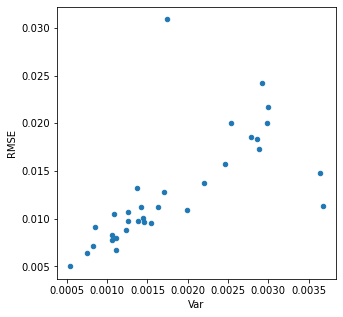

In [31]:
pd.DataFrame(var_list).plot.scatter(figsize=(5,5), x='Var', y='RMSE').figure.savefig('results_graphs/obj1/VarvsRMSE.png', bbox_inches="tight")

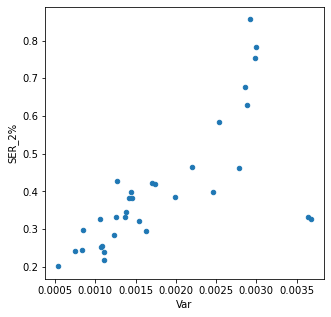

In [30]:
pd.DataFrame(var_list).plot.scatter(figsize=(5,5), x='Var', y='SER_2%').figure.savefig('results_graphs/obj1/VarvsSER2.png', bbox_inches="tight")

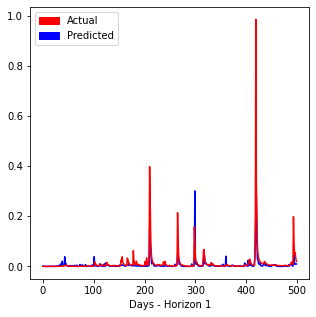

In [14]:
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(5,5))
plt.xlabel('Days - Horizon 1')

ax1 = plt.plot(model_example.predictions('206014')[:,0][1000:1500], color='blue')
ax2 = plt.plot(multi_window.test_windows('206014')[:,0][1000:1500], color='red')

red_patch = mpatches.Patch(color='red', label='Actual')
blue_patch = mpatches.Patch(color='blue', label='Predicted')

plt.legend(handles=[red_patch, blue_patch])
plt.show()

#fig.figure.savefig('results_graphs/obj1/example_3_1.png', bbox_inches="tight")

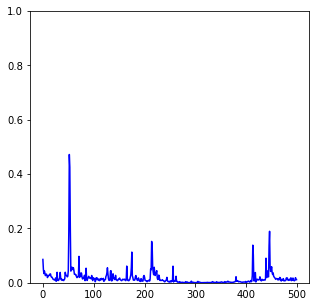

In [50]:
fig = plt.figure(figsize=(5,5))
plt.plot(model_switch.predictions('419005')[:,0][1600:2100], color='blue')
plt.ylim(0, 1)
fig.figure.savefig('results_graphs/obj2/example_1_1.png', bbox_inches="tight")

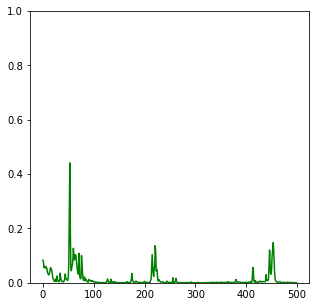

In [51]:
fig = plt.figure(figsize=(5,5))
plt.plot(model_example.predictions('419005')[:,0][1600:2100], color='green')
plt.ylim(0, 1)
fig.figure.savefig('results_graphs/obj2/example_1_2.png', bbox_inches="tight")

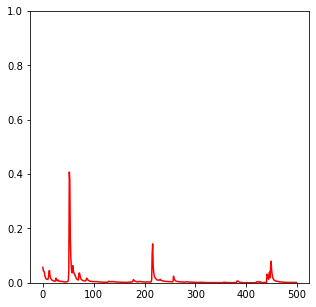

In [52]:
fig = plt.figure(figsize=(5,5))
plt.plot(multi_window.test_windows('419005')[:,0][1600:2100], color='red')
plt.ylim(0, 1)
fig.figure.savefig('results_graphs/obj2/example_1_3.png', bbox_inches="tight")

In [ ]:
1000:1500 - 206014

In [ ]:
plt.plot(model_example.predictions('419005')[:,0][1000:1500], color='blue')

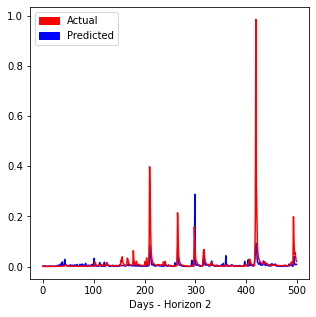

In [46]:
fig = plt.figure(figsize=(5,5))
plt.xlabel('Days - Horizon 2')

ax1 = plt.plot(model_example.predictions('206014')[:,0][1000:1500], color='blue')
ax2 = plt.plot(multi_window.test_windows('206014')[:,0][1000:1500], color='red')

red_patch = mpatches.Patch(color='red', label='Actual')
blue_patch = mpatches.Patch(color='blue', label='Predicted')

plt.legend(handles=[red_patch, blue_patch])
plt.show()

fig.figure.savefig('results_graphs/obj1/example_3_2.png', bbox_inches="tight")

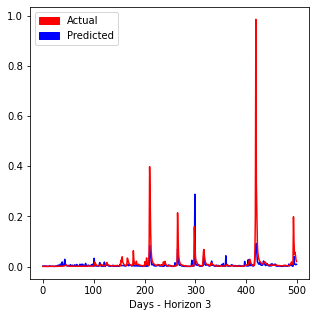

In [47]:
fig = plt.figure(figsize=(5,5))
plt.xlabel('Days - Horizon 3')

ax1 = plt.plot(model_example.predictions('206014')[:,0][1000:1500], color='blue')
ax2 = plt.plot(multi_window.test_windows('206014')[:,0][1000:1500], color='red')

red_patch = mpatches.Patch(color='red', label='Actual')
blue_patch = mpatches.Patch(color='blue', label='Predicted')

plt.legend(handles=[red_patch, blue_patch])
plt.show()

fig.figure.savefig('results_graphs/obj1/example_3_3.png', bbox_inches="tight")

## Batch Static

In [18]:
selected_stations = ['416003', '416008', '204034']
variable = ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']


train_df, val_df, test_df = camels_data.get_train_val_test(source=variable, stations=selected_stations)
multi_window = MultiWindow(input_width=8,
                           label_width=3,
                           shift=3,
                           train_df=train_df,
                           val_df=val_df,
                           test_df=test_df,
                           stations=selected_stations,
                           label_columns=['streamflow_MLd_inclInfilled'])

model_1 = Base_Model(model_name='multi-LSTM', window=multi_window, CONV_WIDTH=3)

In [14]:
selected_stations = ['416003', '416008', '204034']
variable = ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos']


train_df, val_df, test_df = camels_data.get_train_val_test(source=variable, stations=selected_stations)
multi_window = MultiWindow(input_width=8,
                           label_width=3,
                           shift=3,
                           train_df=train_df,
                           val_df=val_df,
                           test_df=test_df,
                           stations=selected_stations,
                           label_columns=['streamflow_MLd_inclInfilled'])

model = Base_Model(model_name='multi-LSTM', window=multi_window, CONV_WIDTH=3)

In [20]:
selected_stations = list(camels_data.summary_data[camels_data.summary_data['state_outlet'] == 'NSW'].index)
input_widths = [5]
label_widths = [5]
models = ['multi-Bidirectional-LSTM']
variables = [['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']]

permutations_base_batch = list(itertools.product(*[input_widths, label_widths, models, variables]))

results_baseModels_batch = []
errors_baseModels_batch = []

for input_width, label_width, model_name, variable in permutations_base_batch:
    try:
        if input_width < label_width:
            continue

        train_df, val_df, test_df = camels_data.get_train_val_test(source=variable, stations=selected_stations, discard=0.5)
        multi_window = MultiWindow(input_width=input_width,
                                   label_width=label_width,
                                   shift=label_width,
                                   train_df=train_df,
                                   val_df=val_df,
                                   test_df=test_df,
                                   stations=selected_stations,
                                   label_columns=['streamflow_MLd_inclInfilled'])

        model = Base_Model(model_name=model_name, window=multi_window, CONV_WIDTH=label_width)

        print('input_width:{}, label_width:{}, model:{}, variables:{}'.format(input_width, label_width, model_name, variable))
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print(current_time)

        for station in selected_stations:
            results_baseModels_batch.append(model.summary(station=station))
         
        pd.DataFrame(results_baseModels_batch).to_csv('results_files/results_batch_static_all_1.csv')
    except:
        errors_baseModels_batch.append([input_width, label_width, model]) 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\jimln\AppData\Local\Temp/ipykernel_13876/206259940.py", line 17, in <module>
    train_df, val_df, test_df = camels_data.get_train_val_test(source=variable, stations=selected_stations, discard=0.5)
  File "C:\Users\jimln\AppData\Local\Temp/ipykernel_13876/872983616.py", line 96, in get_train_val_test
    all_data = self.get_timeseries_data(timeseries_source, stations).loc[start:end]
  File "C:\Users\jimln\AppData\Local\Temp/ipykernel_13876/872983616.py", line 59, in get_timeseries_data
    self.data_filtered = self.timeseries_data[self.timeseries_data['source'].isin(source)]
  File "C:\Users\jimln\anaconda3\lib\site-packages\pandas\core\frame.py", line 3449, in __getitem__
    return self._getitem_bool_array(key)
  File "C:\Users\jimln\anaconda3\lib\site-packages\pandas\core\frame.py", line 3504, in _getitem_bool_array
    return self._take_with_is_copy(indexer, axis=0)
  File "C:\Users\jimln\anaconda3\lib\site-packages\pandas\core\ge

TypeError: object of type 'NoneType' has no len()

## Ensemble Model

In [42]:
np_window = MultiNumpyWindow(input_width=8, 
                             label_width=3,
                             shift=3,
                             timeseries_source=['streamflow_MLd_inclInfilled', 'precipitation_deficit'],
                             summary_source=['Q95', 'high_q_freq', 'high_q_dur'],
                             summary_data=camels_data.summary_data,
                             stations=['416003', '416008', '204034'],
                             label_columns=['streamflow_MLd_inclInfilled'])

ensemble_model = Ensemble_Static(np_window)
ensemble_model.train()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 TIMESERIES_INPUT (InputLayer)  [(None, 8, 2)]       0           []                               
                                                                                                  
 BIDIRECTIONAL_LAYER_1 (LSTM)   (None, 8, 64)        17152       ['TIMESERIES_INPUT[0][0]']       
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)      (None, 8, 64)        0           ['BIDIRECTIONAL_LAYER_1[0][0]']  
                                                                                                  
 BIDIRECTIONAL_LAYER_2 (LSTM)   (None, 32)           12416       ['DROPOUT_LAYER_1[0][0]']        
                                                                                            

In [58]:
ensemble_model.actuals('416003')

ValueError: cannot reshape array of size 14238 into shape (4746,1)

In [49]:
ensemble_model.predictions('416003').shape

(1582, 3)

In [47]:
ensemble_model.numpy_window.test_windows('416003').shape

(2643, 3)

In [43]:
ensemble_model.summary('416003')

ValueError: operands could not be broadcast together with shapes (1582,) (2643,) 

In [ ]:
selected_stations = ['416003', '416008', '204034', '418005', '206014', '418014', '419005', '206018', '208007', '208009', '410061', '216002', '401015']
input_widths = [5, 10, 15]
label_widths = [1, 2, 3, 4, 5]

permutations_ensemble = list(itertools.product(*[input_widths, label_widths, selected_stations]))
 
results_ensemble = []
                                                 
for input_width, label_width, station in permutations_ensemble:
    np_window = MultiNumpyWindow(input_width=input_width, 
                                 label_width=label_width,
                                 shift=label_width,
                                 timeseries_source=['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP'],
                                 summary_source=['q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq'],
                                 summary_data=camels_data.summary_data,
                                 stations=selected_stations,
                                 label_columns=['streamflow_MLd_inclInfilled'])
    
    ensemble_model = Ensemble_Static(np_window)
    ensemble_model.train()
    print('done')
    
    for station in selected_stations:
        results.append(ensemble_model.summary(station))

## Individual Model

In [130]:
selected_stations = ['416003', '416008', '204034']
variable = ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']

train_df, val_df, test_df = camels_data.get_train_val_test(source=variable, stations=selected_stations)

window = WindowGenerator(input_width=7,
                         label_width=3,
                         shift=3,
                         train_df=train_df,
                         val_df=val_df,
                         test_df=test_df,
                         station='416008',
                         label_columns=['streamflow_MLd_inclInfilled'])

model = Base_Model(model_name='multi-LSTM', window=window, CONV_WIDTH=3)

In [131]:
model.average_model_error(cut=1)

0.38594809853063733

In [111]:
percentile_cut = model.window.station_percentile(cut=1)

preds_pre = model.predictions()
actuals_pre = model.window.test_windows

preds = np.array([int(any(x > percentile_cut)) for x in preds_pre])
actuals = np.array([int(any(x > percentile_cut)) for x in actuals_pre])

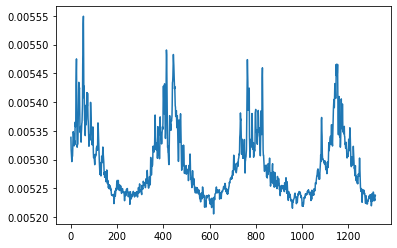

In [112]:
plt.plot(preds_pre[:, 0])

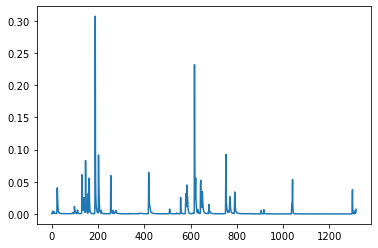

In [113]:
plt.plot(actuals_pre[:, 0])

In [73]:
np.sum(actuals)

30

In [132]:
model.summary()

{'model_name': 'multi-LSTM',
 'input_width': 7,
 'label_width': 3,
 'station': '416008',
 'inputs': "['precipitation_deficit', 'streamflow_MLd_inclInfilled', 'tmax_AWAP', 'tmin_AWAP', 'year_cos', 'year_sin']",
 'NSE': 0.23991083850778294,
 'SERA_1%': 0.38594809853063733,
 'SERA_2%': 0.21908441476339346,
 'SERA_5%': 0.11089276447551809,
 'SERA_10%': 0.058300115893976046,
 'SERA_25%': 0.024639167926742464,
 'SERA_50%': 0.012878133580089653,
 'SERA_75%': 0.008672428694505432,
 'SERA_all': 0.008053210160028322,
 'precision_whole_1%': 0.5675675675675675,
 'precision_whole_2%': 0.5492957746478874,
 'precision_whole_5%': 0.591743119266055,
 'precision_whole_10%': 0.457286432160804,
 'precision_whole_25%': 0.2907975460122699,
 'precision_whole_50%': 0.5201088599939522,
 'precision_whole_75%': 0.7614151799213789,
 'precision_whole_all': 0.8164499546416691,
 'precision_individual_1%': 0.46,
 'precision_individual_2%': 0.4954128440366973,
 'precision_individual_5%': 0.48185483870967744,
 'precisi

In [19]:
selected_stations =['401009',
                     '401012',
                     '401015',
                     '410057',
                     '410061',
                     '410705',
                     '410734',
                     '412028',
                     '412050',
                     '412066',
                     '416003',
                     '416008',
                     '418005',
                     '418014',
                     '424002',
                     '204034',
                     '206014',
                     '206018',
                     '208007',
                     '208009',
                     '210011',
                     '211008',
                     '212209',
                     '212260',
                     '215002',
                     '215004',
                     '215207',
                     '216004']

In [20]:
#['416003', '416008', '204034', '418005', '206014', '418014', '419005', '206018', '208007', '208009', '410061', '216002', '401015']
input_widths = [5]
label_widths = [1, 2, 3, 4, 5]
models = ['multi-LSTM', 'multi-linear', 'multi-CNN', 'multi-Bidirectional-LSTM']
variables = [['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']]

permutations_base = list(itertools.product(*[input_widths, label_widths, selected_stations, models, variables]))
 
results_baseModels_variables = []
models_baseModels_variables = []
errors_baseModels_variables = []

for input_width, label_width, station, model_name, variable in permutations_base:
    if input_width < label_width:
        continue
        
    train_df, val_df, test_df = camels_data.get_train_val_test(source=variable, stations=selected_stations)
     
    try:
        print('input_width:{}, label_width:{}, station:{}, model:{}, variables:{}'.format(input_width, label_width, station, model_name, variable))
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print(current_time)
        
        window = WindowGenerator(input_width=input_width,
                                 label_width=label_width,
                                 shift=label_width,
                                 train_df=train_df,
                                 val_df=val_df,
                                 test_df=test_df,
                                 station=station,
                                 label_columns=['streamflow_MLd_inclInfilled'])

        model = Base_Model(model_name=model_name, window=window, CONV_WIDTH=label_width)
        
        results_baseModels_variables.append(model.summary())
          
        pd.DataFrame(results_baseModels_variables).to_csv('results_files/results_ensemble_all_1.csv')
        
    except:
        errors_baseModels_variables.append([input_width, label_width, station, model])

input_width:5, label_width:1, station:401009, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:05:21
input_width:5, label_width:1, station:401009, model:multi-linear, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:05:51
input_width:5, label_width:1, station:401009, model:multi-CNN, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:06:12
input_width:5, label_width:1, station:401009, model:multi-Bidirectional-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:06:37
input_width:5, label_width:1, station:401012, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:07:02
input_width:5, label_width:1, stati

KeyboardInterrupt: 

## Batch Model

In [22]:
selected_stations = ['416003', '416008', '204034', '418005', '206014', '418014', '419005', '206018', '208007', '208009', '410061', '216002', '401015']
variable = ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']


train_df, val_df, test_df = camels_data.get_train_val_test(source=variable, stations=selected_stations)
multi_window = MultiWindow(input_width=5,
                           label_width=3,
                           shift=3,
                           train_df=train_df,
                           val_df=val_df,
                           test_df=test_df,
                           stations=selected_stations,
                           label_columns=['streamflow_MLd_inclInfilled'])

model = Base_Model(model_name='multi-LSTM', window=multi_window, CONV_WIDTH=3)

In [24]:
model.predictions('416003').shape

(2643, 3)

In [55]:
multi_window.test_windows('416003').shape

(2643, 3)

In [29]:
percentile_cut = model.window.station_percentile(cut=1, station='208009')

preds_pre = model.predictions('208009')
actuals_pre = model.window.test_windows('208009')

preds = np.array([int(any(x > percentile_cut)) for x in preds_pre])
actuals = np.array([int(any(x > percentile_cut)) for x in actuals_pre])

(0.0, 1.0)

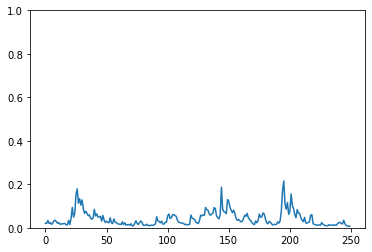

In [46]:
plt.plot(preds_pre[:250, 1])
plt.ylim(0, 1)

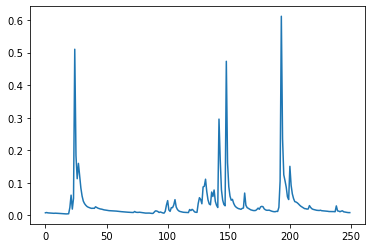

In [47]:
plt.plot(actuals_pre[:250, 1])

In [14]:
selected_stations = list(camels_data.summary_data[camels_data.summary_data['state_outlet'] == 'NSW'].index)
#['416003', '416008', '204034', '418005', '206014', '418014', '419005', '206018', '208007', '208009', '410061', '216002', '401015']
#
input_widths = [5]
label_widths = [1]
models = ['multi-LSTM', 'multi-linear', 'multi-CNN', 'multi-Bidirectional-LSTM']
variables = [['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']]

permutations_base_batch = list(itertools.product(*[input_widths, label_widths, models, variables]))

results_baseModels_batch = []
errors_baseModels_batch = []

for input_width, label_width, model_name, variable in permutations_base_batch:
    try:
        if input_width < label_width:
            continue

        train_df, val_df, test_df = camels_data.get_train_val_test(source=variable, stations=selected_stations, discard=0.5)
        multi_window = MultiWindow(input_width=input_width,
                                   label_width=label_width,
                                   shift=label_width,
                                   train_df=train_df,
                                   val_df=val_df,
                                   test_df=test_df,
                                   stations=selected_stations,
                                   label_columns=['streamflow_MLd_inclInfilled'])

        model = Base_Model(model_name=model_name, window=multi_window, CONV_WIDTH=label_width)

        print('input_width:{}, label_width:{}, model:{}, variables:{}'.format(input_width, label_width, model_name, variable))
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print(current_time)

        for station in selected_stations:
            results_baseModels_batch.append(model.summary(station=station))
         
        pd.DataFrame(results_baseModels_batch).to_csv('results_files/results_batch_all_1.csv')
    except:
        errors_baseModels_batch.append([input_width, label_width, model_name]) 

input_width:5, label_width:1, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
19:47:34
input_width:5, label_width:1, model:multi-linear, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:16:57
input_width:5, label_width:1, model:multi-CNN, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
20:44:48
input_width:5, label_width:1, model:multi-Bidirectional-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
21:14:42


In [77]:
multi_window.station_percentile(station='416003', cut=25)

8.701595388319137e-06

In [15]:
selected_stations = ['416003', '416008', '204034', '418005', '206014', '418014', '419005', '206018', '208007', '208009']
variable = ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'upper_soil', 'deep_soil']

train_df, val_df, test_df = camels_data.get_train_val_test(source=variable, stations=selected_stations, discard=0.5)
 
multi_window = MultiWindow(input_width=5,
                           label_width=3,
                           shift=3,
                           train_df=train_df,
                           val_df=val_df,
                           test_df=test_df,
                           stations=selected_stations,
                           label_columns=['streamflow_MLd_inclInfilled'])

model = Base_Model(model_name='multi-LSTM', window=multi_window, CONV_WIDTH=3)

In [135]:
percentile_cut = model.window.station_percentile(station='416008', cut=1)

preds = np.array([int(x > percentile_cut) for x in model.predictions('416008').flatten()])           
actuals = np.array([int(x > percentile_cut) for x in model.window.test_windows('416008').flatten()])

In [140]:
np.sum(actuals)

20

In [141]:
np.sum(preds)

16

In [132]:
model.window.station_percentile(station='416008', cut=99)

0.0

In [106]:
model.binary_metrics(station='418005', cut=1, metric='accuracy', evaluation='individual')

0.9034552845528455

In [130]:
model.summary(station='416008')

{'model_name': 'multi-LSTM',
 'input_width': 5,
 'label_width': 3,
 'station': '416008',
 'inputs': "['deep_soil', 'precipitation_deficit', 'streamflow_MLd_inclInfilled', 'upper_soil']",
 'predictions': array([[0.00054246, 0.00151983, 0.00251463],
        [0.00036287, 0.00111359, 0.00192928],
        [0.00029606, 0.00094408, 0.00166899],
        ...,
        [0.00266513, 0.00413254, 0.00463241],
        [0.00167492, 0.0032624 , 0.00412264],
        [0.00476938, 0.00634781, 0.00688693]], dtype=float32),
 'actuals': array([[0.00165836, 0.00135734, 0.00117362],
        [0.00135734, 0.00117362, 0.00102587],
        [0.00117362, 0.00102587, 0.00085838],
        ...,
        [0.00168632, 0.0021552 , 0.00711961],
        [0.0021552 , 0.00711961, 0.03137476],
        [0.00711961, 0.03137476, 0.02583795]]),
 'NSE': 0.0499180791579135,
 'SERA_1%': 0.01034423846213036,
 'SERA_2%': 0.0062208600864438746,
 'SERA_5%': 0.003999822652827056,
 'SERA_10%': 0.0025290007683793163,
 'SERA_25%': 0.001108079

## Switch

In [115]:
cut = multi_window.station_percentile(station='212209', cut=99)

In [116]:
cut

0.07159364969266772

In [67]:
multi_window.test_windows('419005')

0.08137432308054553

In [14]:
model_normal = Base_Model(model_name='multi-LSTM', window=multi_window, CONV_WIDTH=3)

NameError: name 'multi_window' is not defined

In [17]:
preds = model.predictions('419005')
actuals = multi_window.test_windows('419005')

In [24]:
percentile_1 = multi_window.station_percentile(station='419005', cut=1)
percentile_2 = multi_window.station_percentile(station='419005', cut=2)
percentile_5 = multi_window.station_percentile(station='419005', cut=5)
percentile_5 = multi_window.station_percentile(station='419005', cut=5)

In [25]:
percentile_2

0.09211131668997613

In [90]:
preds.flatten()

array([0.01643801, 0.02176437, 0.02641022, ..., 0.00979003, 0.01016212,
       0.00892195], dtype=float32)

In [102]:
np.array([int(x > cut_1) for x in model_normal.predictions('419005').flatten()]).shape

(4719,)

In [13]:
def binary_metrics(station, cut, metric, evaluation='whole'):
    percentile_cut = multi_window.station_percentile(station=station, cut=cut)
   
    
    if evaluation=='whole':  
        preds = np.array([int(any(x > percentile_cut)) for x in model_normal.predictions(station)])
        actuals = np.array([int(any(x > percentile_cut)) for x in multi_window.test_windows(station)])
    else:
        preds = np.array([int(x > percentile_cut) for x in model_normal.predictions(station).flatten()])           
        actuals = np.array([int(x > percentile_cut) for x in multi_window.test_windows(station).flatten()])
        
    if metric=='accuracy':
        return accuracy_score(actuals, preds)
    elif metric=='precision':
        return precision_score(actual, preds)
    elif metric=='recall':
        return recall_score(actual, preds)
    elif metric=='f1_score':
        return f1_score(actual, preds)

In [110]:
rocauc('419005', 99, 'afe')

0.9564796905222437

In [79]:
.shape

(1573,)

In [87]:
roc_auc_score(np.array([int(any(x > cut_1)) for x in multi_window.test_windows('419005')]), np.array([int(any(x > cut_1)) for x in preds]))

0.7032473448933686

In [14]:
selected_stations = list(camels_data.summary_data[camels_data.summary_data['state_outlet'] == 'NSW'].index)
#['416003', '416008', '204034', '418005', '206014', '418014', '419005', '206018', '208007', '208009', '410061', '216002', '401015']
#
variable_ts = ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
variable_ts_switch = ['flood_probabilities', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'upper_soil', 'deep_soil']

variable_static = ['q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']

results_switch = []

for label_width in [1,2,3,4,5]:
    train_df, val_df, test_df = camels_data.get_train_val_test(source=variable_ts, stations=selected_stations)
    multi_window = MultiWindow(input_width=5,
                               label_width=label_width,
                               shift=label_width,
                               train_df=train_df,
                               val_df=val_df,
                               test_df=test_df,
                               stations=selected_stations,
                               label_columns=['streamflow_MLd_inclInfilled'])

    
    np_window = MultiNumpyWindow(input_width=5, 
                                 label_width=1,
                                 shift=1,
                                 timeseries_source=variable_ts_switch,
                                 summary_source=variable_static,
                                 summary_data=camels_data.summary_data,
                                 stations=selected_stations,
                                 label_columns=['flood_probabilities'])    
    
    
    model_switch = Switch_Model(window_switch=np_window, window_regular=multi_window, CONV_WIDTH=label_width)       

    print(datetime.now().strftime("%H:%M:%S"))

    for station in selected_stations:
        results_switch.append(model_switch.summary(station=station))

        
    pd.DataFrame(results_switch).to_csv('results_files/results_switch.csv')  

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 TIMESERIES_INPUT (InputLayer)  [(None, 5, 8)]       0           []                               
                                                                                                  
 BIDIRECTIONAL_LAYER_1 (LSTM)   (None, 5, 64)        18688       ['TIMESERIES_INPUT[0][0]']       
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)      (None, 5, 64)        0           ['BIDIRECTIONAL_LAYER_1[0][0]']  
                                                                                                  
 BIDIRECTIONAL_LAYER_2 (LSTM)   (None, 32)           12416       ['DROPOUT_LAYER_1[0][0]']        
                                                                                              

In [87]:
selected_stations = ['419005', '418005', '204034', '212209', '401009', '215004']
#list(camels_data.summary_data[camels_data.summary_data['state_outlet'] == 'NSW'].index)

variable_ts = ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
variable_ts_switch = ['flood_probabilities', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'upper_soil', 'deep_soil']

variable_static = ['q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq']

train_df, val_df, test_df = camels_data.get_train_val_test(source=variable_ts, stations=selected_stations)

multi_window = MultiWindow(input_width=5,
                           label_width=3,
                           shift=3,
                           train_df=train_df,
                           val_df=val_df,
                           test_df=test_df,
                           stations=selected_stations,
                           label_columns=['streamflow_MLd_inclInfilled'])

np_window = MultiNumpyWindow(input_width=5, 
                             label_width=1,
                             shift=1,
                             timeseries_source=variable_ts_switch,
                             summary_source=variable_static,
                             summary_data=camels_data.summary_data,
                             stations=selected_stations,
                             label_columns=['flood_probabilities'])

model_switch = Switch_Model(window_switch=np_window, window_regular=multi_window, CONV_WIDTH=3)                   

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 TIMESERIES_INPUT (InputLayer)  [(None, 5, 8)]       0           []                               
                                                                                                  
 BIDIRECTIONAL_LAYER_1 (LSTM)   (None, 5, 64)        18688       ['TIMESERIES_INPUT[0][0]']       
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)      (None, 5, 64)        0           ['BIDIRECTIONAL_LAYER_1[0][0]']  
                                                                                                  
 BIDIRECTIONAL_LAYER_2 (LSTM)   (None, 32)           12416       ['DROPOUT_LAYER_1[0][0]']        
                                                                                            

In [79]:
#ensemble_model = Ensemble_Static(np_window)
#ensemble_model.train()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 TIMESERIES_INPUT (InputLayer)  [(None, 5, 8)]       0           []                               
                                                                                                  
 BIDIRECTIONAL_LAYER_1 (LSTM)   (None, 5, 64)        18688       ['TIMESERIES_INPUT[0][0]']       
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)      (None, 5, 64)        0           ['BIDIRECTIONAL_LAYER_1[0][0]']  
                                                                                                  
 BIDIRECTIONAL_LAYER_2 (LSTM)   (None, 32)           12416       ['DROPOUT_LAYER_1[0][0]']        
                                                                                            

In [94]:
model_switch.summary('419005')

3163
0
3163
3163
0
3163
3163
0
3163
3163
0
3163
3163
0
3163
3163
0
3163
3163
0
3163
3163
0
3163
3163
0
3163


{'input_width': 5,
 'label_width': 3,
 'station': '419005',
 'NSE': 0.35332346461033143,
 'SER_1%': 0.34911192567740396,
 'SER_2%': 0.20813030792825707,
 'SER_5%': 0.09146293958478463,
 'SER_10%': 0.048995899181664665,
 'SER_25%': 0.020828333967008974,
 'SER_50%': 0.010791832060126553,
 'SER_75%': 0.0072191870164498495,
 'RMSE': 0.005468306961592559}

In [80]:
multi_window.test_windows('419005').shape

(3157, 3)

In [81]:
np_window.test_windows('419005').shape

(3163, 1)

In [82]:
np_window.test[2].shape

(18978, 1, 1)

In [83]:
ensemble_model.test_static_x.shape[0]

18978

In [84]:
ensemble_model.predictions('419005').shape

3163
0
3163


(3163, 1)

In [54]:
ensemble_model.test_df

AttributeError: 'Ensemble_Static' object has no attribute 'test_df'

In [25]:
model.average_model_error(station='419005', cut=100)

IndexError: index 2371 is out of bounds for axis 0 with size 2371

In [36]:
model.predictions('419005').shape

(1896, 3)

In [37]:
model.window.test_windows('419005').shape

(3157, 3)

In [41]:
a = model.average_model_error(station='419005', cut=100)

AttributeError: 'Switch_Model' object has no attribute 'window'

In [32]:
print(dir(model))

['_SCALAR_UPRANKING_ON', '_TF_MODULE_IGNORED_PROPERTIES', '__call__', '__class__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_trackable', '_add_trackable_child', '_add_variable_with_custom_getter', '_assert_compile_was_called', '_assert_weights_created', '_autographed_call', '_call_accepts_kwargs', '_call_arg_was_passed', '_call_fn_arg_defaults', '_call_fn_arg_positions', '_call_fn_args', '_call_full_argspec', '_cast_single_input', '_check_call_args', '_checkpoint_dependencies', '_clear_losses', '_compile_was_called', '_compute_dtype', '_configure_steps_per_execution', '_dedup_weights', '_deferred_dependencies', '_delete_tracking', '_dese

In [27]:
a.shape

(1573, 3)

In [29]:
model.window_regular.test_windows('419005').shape

(1573, 3)

## Extreme Value Loss Function

In [13]:
selected_stations = list(camels_data.summary_data[camels_data.summary_data['state_outlet'] == 'NSW'].index)
#['416003', '416008', '204034', '418005', '206014', '418014', '419005', '206018', '208007', '208009', '410061', '216002', '401015']
#

label_widths = [1,2,3,4,5]
models = ['multi-LSTM', 'multi-linear', 'multi-CNN', 'multi-Bidirectional-LSTM']
variables = []


results_95 = []
results_90 = []
results_70 = []
results_50 = []

for label_width in [1,2,3,4,5]:
    train_df, val_df, test_df = camels_data.get_train_val_test(source=['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP'], stations=selected_stations)
    multi_window = MultiWindow(input_width=5,
                               label_width=label_width,
                               shift=label_width,
                               train_df=train_df,
                               val_df=val_df,
                               test_df=test_df,
                               stations=selected_stations,
                               label_columns=['streamflow_MLd_inclInfilled'])

    model_95 = Base_Model(model_name='multi-LSTM', window=multi_window, CONV_WIDTH=label_width, loss_func=CustomLoss.qloss_95)
    model_90 = Base_Model(model_name='multi-LSTM', window=multi_window, CONV_WIDTH=label_width, loss_func=CustomLoss.qloss_90)
    model_70 = Base_Model(model_name='multi-LSTM', window=multi_window, CONV_WIDTH=label_width, loss_func=CustomLoss.qloss_70)
    model_50 = Base_Model(model_name='multi-LSTM', window=multi_window, CONV_WIDTH=label_width, loss_func=CustomLoss.qloss_50)
    

    print(datetime.now().strftime("%H:%M:%S"))

    for station in selected_stations:
        results_95.append(model_95.summary(station=station))
        results_90.append(model_90.summary(station=station))
        results_70.append(model_70.summary(station=station))
        results_50.append(model_50.summary(station=station))
        
    pd.DataFrame(results_95).to_csv('results_files/results_95.csv')
    pd.DataFrame(results_90).to_csv('results_files/results_90.csv')
    pd.DataFrame(results_70).to_csv('results_files/results_70.csv')
    pd.DataFrame(results_50).to_csv('results_files/results_50.csv')        

23:28:52
02:24:24
05:22:34
08:36:51
11:58:55


In [14]:
selected_stations = list(camels_data.summary_data[camels_data.summary_data['state_outlet'] == 'NSW'].index)
variable = ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']

train_df, val_df, test_df = camels_data.get_train_val_test(source=variable, stations=selected_stations, discard=0)


multi_window = MultiWindow(input_width=5,
                           label_width=3,
                           shift=3,
                           train_df=train_df,
                           val_df=val_df,
                           test_df=test_df,
                           stations=selected_stations,
                           label_columns=['streamflow_MLd_inclInfilled'])

In [25]:
model_1 = Base_Model(model_name='multi-LSTM', window=multi_window, CONV_WIDTH=3, loss_func=CustomLoss.ev_loss_2)
model_2 = Base_Model(model_name='multi-LSTM', window=multi_window, CONV_WIDTH=3, loss_func=CustomLoss.ev_loss_3)
model_normal = Base_Model(model_name='multi-LSTM', window=multi_window, CONV_WIDTH=3)

In [15]:
model_3 = Base_Model(model_name='multi-LSTM', window=multi_window, CONV_WIDTH=3, loss_func=CustomLoss.ev_loss_4)
model_4 = Base_Model(model_name='multi-LSTM', window=multi_window, CONV_WIDTH=3, loss_func=CustomLoss.ev_loss_5)

In [27]:
a_1 = []

for station in selected_stations:
    a_1.append(model_1.summary(station))

KeyboardInterrupt: 

In [ ]:
a_2 = []

for station in selected_stations:
    a_2.append(model_2.summary(station=station))

In [18]:
a_3 = []

for station in selected_stations:
    a_3.append(model_3.summary(station=station))

In [19]:
a_4 = []

for station in selected_stations:
    a_4.append(model_4.summary(station=station))

In [26]:
a_normal = []

for station in selected_stations:
    a_normal.append(model_normal.summary(station=station))

In [42]:
pd.DataFrame(a_3)['SER_10%'].mean()

0.08165100833669496

In [43]:
pd.DataFrame(a_4)['SER_10%'].mean()

0.08487677667220087

In [44]:
pd.DataFrame(a_normal)['SER_10%'].mean()

0.08279917192260582

In [82]:
model_1.print_model_error(station='418005', cut=99)

time: 16
Input: [0.01843235 0.01696762 0.01247048 0.00973109 0.00837903 0.00750169
 0.00675255]
Predicted: [0.00174102 0.00499189 0.00553793]
Actual: [0.00624928 0.05712966 0.1216858 ]
-------------------------
time: 17
Input: [0.01696762 0.01247048 0.00973109 0.00837903 0.00750169 0.00675255
 0.00624928]
Predicted: [0.00187698 0.00567234 0.00579926]
Actual: [0.05712966 0.1216858  0.08681744]
-------------------------
time: 18
Input: [0.01247048 0.00973109 0.00837903 0.00750169 0.00675255 0.00624928
 0.05712966]
Predicted: [0.01068148 0.01479867 0.01217613]
Actual: [0.1216858  0.08681744 0.02931467]
-------------------------
time: 22
Input: [0.00675255 0.00624928 0.05712966 0.1216858  0.08681744 0.02931467
 0.01968405]
Predicted: [0.00201181 0.00534469 0.00476399]
Actual: [0.01514715 0.01709085 0.13646065]
-------------------------
time: 23
Input: [0.00624928 0.05712966 0.1216858  0.08681744 0.02931467 0.01968405
 0.01514715]
Predicted: [0.00357631 0.01208988 0.0073615 ]
Actual: [0.017

In [83]:
model_normal.print_model_error(station='418005', cut=99)

time: 16
Input: [0.01843235 0.01696762 0.01247048 0.00973109 0.00837903 0.00750169
 0.00675255]
Predicted: [0.00299582 0.00606704 0.00911474]
Actual: [0.00624928 0.05712966 0.1216858 ]
-------------------------
time: 17
Input: [0.01696762 0.01247048 0.00973109 0.00837903 0.00750169 0.00675255
 0.00624928]
Predicted: [0.00289708 0.00572366 0.00848794]
Actual: [0.05712966 0.1216858  0.08681744]
-------------------------
time: 18
Input: [0.01247048 0.00973109 0.00837903 0.00750169 0.00675255 0.00624928
 0.05712966]
Predicted: [0.01684842 0.0195803  0.02060786]
Actual: [0.1216858  0.08681744 0.02931467]
-------------------------
time: 22
Input: [0.00675255 0.00624928 0.05712966 0.1216858  0.08681744 0.02931467
 0.01968405]
Predicted: [0.00926727 0.01367709 0.01752779]
Actual: [0.01514715 0.01709085 0.13646065]
-------------------------
time: 23
Input: [0.00624928 0.05712966 0.1216858  0.08681744 0.02931467 0.01968405
 0.01514715]
Predicted: [0.01056769 0.0159587  0.0201484 ]
Actual: [0.017

In [65]:
def ev_loss(y_true, y_pred):

    return tf.square(y_true-y_pred) + tf.math.exp(tf.square(y_true-y_pred))

model = Sequential([
        # Shape [batch, time, features] => [batch, lstm_units].
        # Adding more `lstm_units` just overfits more quickly.
        LSTM(32, return_sequences=False),
        # Shape => [batch, out_steps*features].
        Dense(3, activation='linear', kernel_initializer=tf.initializers.zeros()),
        # Shape => [batch, out_steps, features=1].
        Reshape([3, 1])
    ])

In [67]:
model.compile(loss=ev_loss,
            optimizer=tf.optimizers.Adam(),
            metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit(multi_window.train, epochs=50,
                    validation_data=multi_window.val)

Epoch 1/50
2372/2372 [==============================] - 8s 3ms/step - loss: 1.0020 - mean_absolute_error: 0.0099 - val_loss: 1.0007 - val_mean_absolute_error: 0.0123
Epoch 2/50
2372/2372 [==============================] - 5s 2ms/step - loss: 1.0018 - mean_absolute_error: 0.0091 - val_loss: 1.0005 - val_mean_absolute_error: 0.0092
Epoch 3/50
2372/2372 [==============================] - 5s 2ms/step - loss: 1.0018 - mean_absolute_error: 0.0088 - val_loss: 1.0004 - val_mean_absolute_error: 0.0074
Epoch 4/50
2372/2372 [==============================] - 5s 2ms/step - loss: 1.0017 - mean_absolute_error: 0.0086 - val_loss: 1.0003 - val_mean_absolute_error: 0.0056
Epoch 5/50
2372/2372 [==============================] - 5s 2ms/step - loss: 1.0017 - mean_absolute_error: 0.0083 - val_loss: 1.0004 - val_mean_absolute_error: 0.0081
Epoch 6/50
2372/2372 [==============================] - 5s 2ms/step - loss: 1.0017 - mean_absolute_error: 0.0083 - val_loss: 1.0005 - val_mean_absolute_error: 0.0110
Epoc

KeyboardInterrupt: 

## Comparisons

In [119]:
selected_stations = ['419005', '418005', '204034', '212209', '401009', '215004']
variable = ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']

train_df, val_df, test_df = camels_data.get_train_val_test(source=variable, stations=selected_stations, discard=0)


multi_window = MultiWindow(input_width=7,
                           label_width=3,
                           shift=3,
                           train_df=train_df,
                           val_df=val_df,
                           test_df=test_df,
                           stations=selected_stations,
                           filtered=0,
                           label_columns=['streamflow_MLd_inclInfilled'])

model = Base_Model(model_name='multi-LSTM', window=multi_window, CONV_WIDTH=3)

In [29]:
multi_window.test_array().shape

TypeError: test_array() missing 1 required positional argument: 'station'

In [27]:
np.percentile(multi_window.test_array('419005'), 99)

0.10416356086388853

In [ ]:
locs = np.where(actuals>cut_percentile)[0]
preds = preds[locs]
actuals = actuals[locs]

In [28]:
for i in multi_window.train.unbatch().filter(lambda x, y: tf.math.reduce_max(y) > 0.9):
    print(i)

(<tf.Tensor: shape=(7, 12), dtype=float32, numpy=
array([[0.03117685, 0.01782797, 0.40344667, 0.3187009 , 0.23603769,
        0.07535438, 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.03580291, 0.01654659, 0.44773167, 0.3431002 , 0.24338147,
        0.07087655, 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.04117367, 0.0150335 , 0.45633513, 0.5214095 , 0.25080118,
        0.06652571, 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.03186066, 0.01421445, 0.47110966, 0.43282378, 0.25829464,
        0.06230315, 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.02752784, 0.01349323, 0.5140495 , 0.3417712 , 0.26585966,
        0.05821012, 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.03678228, 0.01266658, 0.5274352 , 0.4239214 , 0.27349395,
        0.05424782, 1.        , 0.   

In [32]:
model.get_NSE('419005')

[-171.78805436222189, -219.28510511691684, -209.7513199398325]

In [29]:
model.summary('419005')

{'model_name': 'multi-LSTM',
 'input_width': 7,
 'label_width': 3,
 'station': '419005',
 'inputs': "['precipitation_deficit', 'streamflow_MLd_inclInfilled', 'tmax_AWAP', 'tmin_AWAP', 'year_cos', 'year_sin']",
 'NSE': [-219.9540776194586, -234.66968521796986, -234.60469659848147],
 'test_loss': 0.17767642438411713,
 'val_loss': 0.18361449241638184,
 'average_window_error_1%': 5.923820767128114,
 'average_window_error_5%': 34.771924850030985,
 'average_window_error_10%': 75.91323633665009,
 'average_window_error_25%': 206.7217157550309,
 'average_window_error_50%': 414.8068551998885,
 'average_window_error_75%': 630.1695454500817,
 'average_window_error_all': 863.8976407099493}

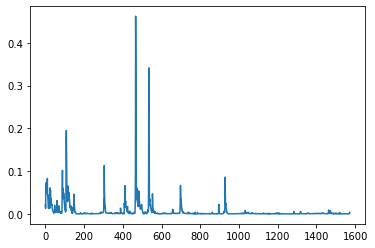

In [120]:
plt.plot(model.predictions('419005')[:, 0])

<AxesSubplot:xlabel='date'>

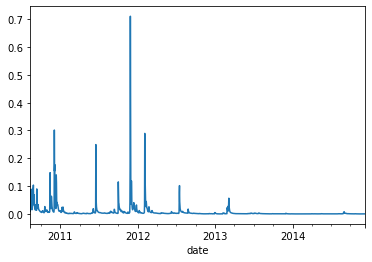

In [24]:
test_df['419005']['streamflow_MLd_inclInfilled'].plot()

In [33]:
convolution_size = 5
total_size = 1582
prediction_size = 3

for i in range(convolution_size+1, (total_size-prediction_size+1)):
    print(i)

6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
28

In [48]:
for i in model.window.test.unbatch():
    print(i)

(<tf.Tensor: shape=(5, 12), dtype=float32, numpy=
array([[0.15348528, 0.00995474, 0.25571638, 0.45636153, 0.11416598,
        0.18198723, 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.12435344, 0.01713115, 0.13660088, 0.41612682, 0.11969351,
        0.1753972 , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.1110102 , 0.02643272, 0.23818696, 0.37549758, 0.12533358,
        0.16890322, 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.03508564, 0.08698805, 0.37007037, 0.20428243, 0.13108452,
        0.16250722, 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.04444901, 0.08711274, 0.32701087, 0.33886245, 0.13694462,
        0.15621111, 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]], dtype=float32)>, <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.0375206 ],
       [0.0244971 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




(<tf.Tensor: shape=(5, 12), dtype=float32, numpy=
array([[0.01385412, 0.00293253, 0.7013567 , 0.771441  , 0.999239  ,
        0.52757496, 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        ],
       [0.01540926, 0.00265619, 0.5164321 , 0.69734824, 0.99869084,
        0.53615874, 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        ],
       [0.01745909, 0.00254278, 0.40200502, 0.66782635, 0.997995  ,
        0.54473186, 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        ],
       [0.00824852, 0.00242479, 0.528691  , 0.5015862 , 0.9971519 ,
        0.5532917 , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        ],
       [0.0213278 , 0.00228142, 0.52825767, 0.7654089 , 0.9961616 ,
        0.56183577, 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        ]], dtype=float32)>, <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.00265479],
       [0.0025833

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [74]:
model.window.test_windows('419005')

array([[3.75206019e-02, 2.44970997e-02, 1.85798069e-02],
       [2.44970997e-02, 1.85798069e-02, 1.53359447e-02],
       [1.85798069e-02, 1.53359447e-02, 1.53126137e-02],
       ...,
       [8.35839808e-06, 3.49106359e-05, 4.71339284e-05],
       [3.49106359e-05, 4.71339284e-05, 1.27698581e-04],
       [4.71339284e-05, 1.27698581e-04, 1.51811897e-04]])

In [44]:
for i in model.window.test_array('419005'):
    print(i)

[0.00995474]
[0.01713115]
[0.02643271]
[0.08698806]
[0.08711274]
[0.0375206]
[0.0244971]
[0.01857981]
[0.01533594]
[0.01531261]
[0.08533209]
[0.09123226]
[0.04226086]
[0.03169909]
[0.08080331]
[0.1036208]
[0.0576334]
[0.04423661]
[0.06895407]
[0.0412283]
[0.02778003]
[0.0218576]
[0.01831343]
[0.01590723]
[0.01444584]
[0.01449089]
[0.03265577]
[0.02992112]
[0.02293082]
[0.01560671]
[0.01305529]
[0.08987446]
[0.08096321]
[0.0375586]
[0.02565166]
[0.02118035]
[0.02468525]
[0.03358805]
[0.02757679]
[0.01916276]
[0.01560339]
[0.01484343]
[0.01404257]
[0.01262238]
[0.01151448]
[0.01056833]
[0.01011355]
[0.00889069]
[0.00790281]
[0.00721034]
[0.00695124]
[0.00642898]
[0.00574302]
[0.00531913]
[0.00525435]
[0.00751768]
[0.00875789]
[0.00921376]
[0.01118378]
[0.00919207]
[0.01027346]
[0.00704257]
[0.00598693]
[0.00514892]
[0.0046562]
[0.00437163]
[0.00450795]
[0.00987397]
[0.01426486]
[0.02644256]
[0.01562073]
[0.01085533]
[0.00894381]
[0.00873458]
[0.01198228]
[0.01053337]
[0.01008672]
[0.0105

In [104]:
model.predictions('419005')[:, 0][105:115]

array([0.0164363 , 0.01999919, 0.12538974, 0.25287917, 0.14466985,
       0.14738964, 0.08264656, 0.04411959, 0.03897129, 0.0386853 ],
      dtype=float32)

In [103]:
model.window.test_windows('419005')[105:115]

array([[0.00658807, 0.01537961, 0.30162354],
       [0.01537961, 0.30162354, 0.15410754],
       [0.30162354, 0.15410754, 0.17722554],
       [0.15410754, 0.17722554, 0.06494563],
       [0.17722554, 0.06494563, 0.04371359],
       [0.06494563, 0.04371359, 0.03266926],
       [0.04371359, 0.03266926, 0.02332788],
       [0.03266926, 0.02332788, 0.0191801 ],
       [0.02332788, 0.0191801 , 0.02220339],
       [0.0191801 , 0.02220339, 0.14025771]])

In [ ]:
## Diagnose windows
## NSE Error
## 2% error

In [147]:
numer = 0
denom = 0

for i in range(3):
    numer += np.sum(np.square(model.predictions('419005')[:, i] - model.window.test_windows('419005')[:, i]))
    denom += np.sum(np.square(model.window.test_windows('419005')[:, i] - np.mean(model.window.test_windows('419005')[:, i])))

In [148]:
1 - numer/denom

0.38076157780772313

In [122]:
np.sum(np.square(model.predictions('419005')[:, i] - model.window.test_windows('419005')[:, i]))/np.var(model.window.test_windows('419005')[:, 0])

1238.4822112884392

1.2672093486082936

In [111]:
model.predictions('419005')

array([[0.03780347, 0.0101418 , 0.01178372],
       [0.03836159, 0.01246161, 0.0141163 ],
       [0.11397743, 0.09864445, 0.08191194],
       ...,
       [0.00929269, 0.00777234, 0.00753669],
       [0.01170107, 0.01666484, 0.01467603],
       [0.02829094, 0.02967577, 0.02291569]], dtype=float32)

In [119]:
model.window.test_windows('419005')[:, 0]

array([1.85798069e-02, 1.53359447e-02, 1.53126137e-02, ...,
       8.35839808e-06, 3.49106359e-05, 4.71339284e-05])

In [95]:
model.print_model_error('419005', cut=99)

(1573, 3)
(1573, 3)
time: 85
Input: [0.00548554 0.00753286 0.00803615 0.0063455  0.00584438 0.00735588
 0.00660189]
Predicted: [0.01594136 0.01498933 0.01619042]
Actual: [0.00727538 0.1006721  0.14834222]
-------------------------
time: 86
Input: [0.00753286 0.00803615 0.0063455  0.00584438 0.00735588 0.00660189
 0.00727538]
Predicted: [0.04680431 0.04329136 0.03533448]
Actual: [0.1006721  0.14834222 0.05260322]
-------------------------
time: 87
Input: [0.00803615 0.0063455  0.00584438 0.00735588 0.00660189 0.00727538
 0.1006721 ]
Predicted: [0.09476411 0.06394028 0.05262023]
Actual: [0.14834222 0.05260322 0.02762281]
-------------------------
time: 105
Input: [0.01531047 0.0126349  0.01055045 0.00902268 0.00787245 0.00700924
 0.00650703]
Predicted: [0.0164363  0.01385618 0.01610969]
Actual: [0.00658807 0.01537961 0.30162354]
-------------------------
time: 106
Input: [0.0126349  0.01055045 0.00902268 0.00787245 0.00700924 0.00650703
 0.00658807]
Predicted: [0.01999919 0.01311016 0.01

<AxesSubplot:xlabel='date'>

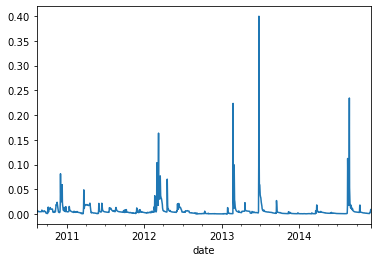

In [17]:
test_df['212209']['streamflow_MLd_inclInfilled'].plot()

In [15]:
test_df['212209']['streamflow_MLd_inclInfilled']

date
2010-08-11    0.007399
2010-08-12    0.004771
2010-08-13    0.004869
2010-08-14    0.005562
2010-08-15    0.005396
                ...   
2014-12-05    0.006680
2014-12-06    0.009268
2014-12-07    0.004408
2014-12-08    0.004386
2014-12-09    0.004212
Name: streamflow_MLd_inclInfilled, Length: 1582, dtype: float64

<AxesSubplot:xlabel='date'>

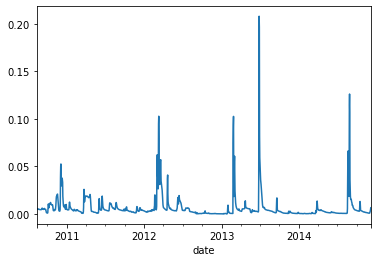

In [18]:
-test_df['212209']['streamflow_MLd_inclInfilled'].rolling(3).mean().plot()

## Filtering Method

In [39]:
selected_stations = list(camels_data.summary_data[camels_data.summary_data['state_outlet'] == 'NSW'].index)
cuts = [-1000, 0.3, 0.5, 0.7]

results_baseModels_batch = []
errors_baseModels_batch = []

for cut in cuts:
    train_df, val_df, test_df = camels_data.get_train_val_test(source=['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP'], stations=selected_stations, discard=0.2)
    multi_window = MultiWindow(input_width=10,
                               label_width=3,
                               shift=3,
                               train_df=train_df,
                               val_df=val_df,
                               test_df=test_df,
                               stations=selected_stations,
                               filtered=cut,
                               label_columns=['streamflow_MLd_inclInfilled'])

    model = Base_Model(model_name='multi-LSTM', window=multi_window, CONV_WIDTH=3)

    for station in selected_stations:
        results_baseModels_batch.append(model.summary(station=station))

    pd.DataFrame(results_baseModels_batch).to_csv('results_batch_filtering.csv')


In [56]:
window_error_names_list = ['average_window_error_1%', 'average_window_error_5%', 'average_window_error_10%', 'average_window_error_25%', 'average_window_error_50%', 'average_window_error_75%', 'average_window_error_all']

results_batch_filtering.groupby('cut')[window_error_names_list].mean()

average_window_error_1%  average_window_error_5%  \
cut                                                     
0.0                 2.582719                 3.241222   
0.3                 2.527708                 9.195401   
0.5                 3.562574                18.687067   
0.7                 4.540109                25.882748   

     average_window_error_10%  average_window_error_25%  \
cut                                                       
0.0                  3.512076                  3.735001   
0.3                 19.107367                 51.263912   
0.5                 39.915771                105.573513   
0.7                 55.430170                146.440426   

     average_window_error_50%  average_window_error_75%  \
cut                                                       
0.0                  3.965125                  4.096981   
0.3                105.909978                156.925150   
0.5                216.748694                325.169759   
0.7                300.186858                450.023109   

     average_window_error_all  
cut                            
0.0                  4.190875  
0.3                200.273436  
0.5                425.126651  
0.7                588.498564

## Baseline models for Window Prediction - Individual Station

In [90]:
selected_stations = ['416003', '416008', '204034', '418005', '206014', '418014', '419005', '206018', '208007', '208009']
variable = ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'upper_soil', 'deep_soil']

train_df, val_df, test_df = camels_data.get_train_val_test(source=variable, stations=selected_stations, discard=0)

window = WindowGenerator(input_width=7,
                         label_width=3,
                         shift=3,
                         train_df=train_df,
                         val_df=val_df,
                         test_df=test_df,
                         station='416003',
                         label_columns=['streamflow_MLd_inclInfilled'])

model = Base_Model(model_name='multi-deep-LSTM', window=window, CONV_WIDTH=3)

KeyboardInterrupt: 

In [85]:
model.summary()

{'model_name': 'multi-deep-LSTM',
 'input_width': 7,
 'label_width': 3,
 'num_features': 4,
 'inputs': ['deep_soil',
  'precipitation_deficit',
  'streamflow_MLd_inclInfilled',
  'upper_soil'],
 'station': '416003',
 'test_loss': 5.820249953103485e-06,
 'val_loss': 3.708386793732643e-05,
 'average_window_error_1%': 0.001850539414281269,
 'average_window_error_5%': 0.0007757924885898309,
 'average_window_error_10%': 0.00048322737720306276,
 'average_window_error_25%': 0.000232607616615305,
 'average_window_error_50%': 0.00012684123946200924,
 'average_window_error_75%': 8.959418007024016e-05,
 'average_window_error_all': 7.67807918704321e-05}

In [ ]:
selected_stations = list(camels_data.summary_data[camels_data.summary_data['state_outlet'] == 'NSW'].index)
input_widths = [5, 10]
label_widths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
models = ['multi-LSTM', 'multi-linear', 'multi-CNN', 'multi-LSTM', 'multi-deep-LSTM', 'multi-Bidirectional-LSTM']
variables = [['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP'],
             ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'upper_soil', 'deep_soil']]

permutations_base = list(itertools.product(*[input_widths, label_widths, selected_stations, models, variables]))
 
results_baseModels_variables = []
models_baseModels_variables = []
errors_baseModels_variables = []

for input_width, label_width, station, model_name, variable in permutations_base:
    if input_width < label_width:
        continue
        
    train_df, val_df, test_df = camels_data.get_train_val_test(source=variable, stations=selected_stations, discard=0.2)
     
    try:
        print('input_width:{}, label_width:{}, station:{}, model:{}, variables:{}'.format(input_width, label_width, station, model_name, variable))
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print(current_time)
        
        window = WindowGenerator(input_width=input_width,
                                 label_width=label_width,
                                 shift=label_width,
                                 train_df=train_df,
                                 val_df=val_df,
                                 test_df=test_df,
                                 station=station,
                                 label_columns=['streamflow_MLd_inclInfilled'])

        model = Base_Model(model_name=model_name, window=window, CONV_WIDTH=label_width)
        
        results_baseModels_variables.append(model.summary())
        models_baseModels_variables.append({'input_width':input_width, 
                       'label_width':label_width,
                       'station':station,
                       'model_name':model_name,
                       'model':model})
        
    except:
        errors_baseModels_variables.append([input_width, label_width, station, model])

input_width:5, label_width:1, station:401009, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
input_width:5, label_width:1, station:401009, model:multi-LSTM, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'upper_soil', 'deep_soil']
input_width:5, label_width:1, station:401009, model:multi-linear, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
input_width:5, label_width:1, station:401009, model:multi-linear, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'upper_soil', 'deep_soil']
input_width:5, label_width:1, station:401009, model:multi-CNN, variables:['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']
input_width:5, label_width:1, station:

## Baseline models for Window Prediction - Batch Station

In [9]:
selected_stations = ['416003', '416008', '204034', '418005', '206014', '418014', '419005', '206018', '208007', '208009']
variable = ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'upper_soil', 'deep_soil']

train_df, val_df, test_df = camels_data.get_train_val_test(source=variable, stations=selected_stations, discard=0.5)
 
multi_window = MultiWindow(input_width=5,
                           label_width=3,
                           shift=3,
                           train_df=train_df,
                           val_df=val_df,
                           test_df=test_df,
                           stations=selected_stations,
                           label_columns=['streamflow_MLd_inclInfilled'])

model = Base_Model(model_name='multi-deep-LSTM', window=multi_window, CONV_WIDTH=3)

NameError: name 'camels_data' is not defined

In [90]:
len(list(camels_data.summary_data[camels_data.summary_data['state_outlet'] == 'NSW'].index))

33

In [32]:
selected_stations = list(camels_data.summary_data[camels_data.summary_data['state_outlet'] == 'NSW'].index)
input_widths = [5]
label_widths = [1, 2, 3, 4, 5]
models = ['multi-LSTM', 'multi-linear', 'multi-CNN', 'multi-Bidirectional-LSTM']
variables = ['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP']

permutations_base_batch = list(itertools.product(*[input_widths, label_widths, models, variables]))

results_baseModels_batch = []
errors_baseModels_batch = []

for input_width, label_width, model_name, variable in permutations_base_batch:
    try:
        if input_width < label_width:
            continue

        train_df, val_df, test_df = camels_data.get_train_val_test(source=variable, stations=selected_stations, discard=0.2)
        multi_window = MultiWindow(input_width=input_width,
                                   label_width=label_width,
                                   shift=label_width,
                                   train_df=train_df,
                                   val_df=val_df,
                                   test_df=test_df,
                                   stations=selected_stations,
                                   label_columns=['streamflow_MLd_inclInfilled'])

        model = Base_Model(model_name=model_name, window=multi_window, CONV_WIDTH=label_width)

        print('input_width:{}, label_width:{}, model:{}, variables:{}'.format(input_width, label_width, model_name, variable))
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print(current_time)

        for station in selected_stations:
            results_baseModels_batch.append(model.summary(station=station))
         
        pd.DataFrame(results_baseModels_batch).to_csv('results_batch_NSW.csv')
    except:
        errors_baseModels_batch.append([input_width, label_width,model_name]) 

NameError: name 'model' is not defined

### Results

In [1]:
window_error_names_list = ['average_window_error_1%', 'average_window_error_5%', 'average_window_error_10%', 'average_window_error_25%', 'average_window_error_50%', 'average_window_error_75%', 'average_window_error_all']

In [5]:
df_baseline_batch = pd.read_csv('results_batch_1.csv')
df_baseline_batch['inputs'] = df_baseline_batch['inputs'].astype(str)
df_baseline_batch = df_baseline_batch[df_baseline_batch['input_width'] != 10]
df_baseline_batch = df_baseline_batch[df_baseline_batch['inputs'] != "['deep_soil', 'precipitation_deficit', 'streamflow_MLd_inclInfilled', 'tmax_AWAP', 'tmin_AWAP', 'upper_soil', 'year_cos', 'year_sin']"]

In [6]:
melted_baseline_batch = pd.melt(df_baseline_batch,
                                    id_vars=['model_name', 'input_width', 'label_width', 'station', 'inputs'],
                                    value_vars=['average_window_error_1%', 'average_window_error_5%', 'average_window_error_10%', 'average_window_error_25%', 'average_window_error_50%', 'average_window_error_75%', 'average_window_error_all'],
                                    var_name="average_error",
                                    value_name="Value")

summary_baseline_batch = df_baseline_batch.groupby(['model_name'])[window_error_names_list].describe()

<AxesSubplot:xlabel='model_name,label_width'>

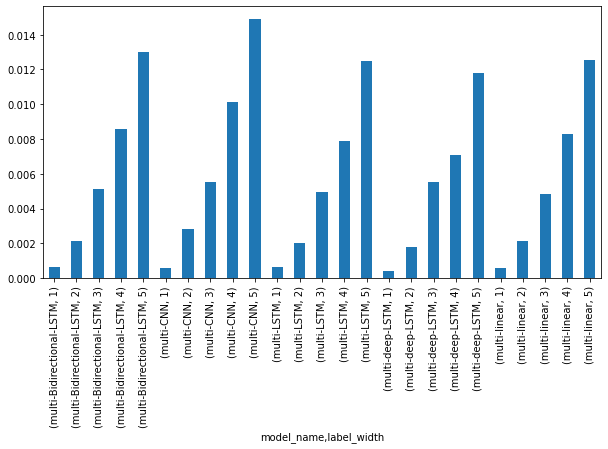

In [129]:
# How error changes with label_width
df_baseline_batch.groupby(['model_name', 'label_width'])['average_window_error_all'].mean().plot(kind='bar', figsize=(10, 5))

In [113]:
# window errror across inputs
df_baseline_batch.groupby('inputs')[window_error_names_list].mean()

average_window_error_1%  \
inputs                                                                        
['precipitation_deficit', 'streamflow_MLd_inclI...                 0.183082   

                                                    average_window_error_5%  \
inputs                                                                        
['precipitation_deficit', 'streamflow_MLd_inclI...                 0.064425   

                                                    average_window_error_10%  \
inputs                                                                         
['precipitation_deficit', 'streamflow_MLd_inclI...                  0.038298   

                                                    average_window_error_25%  \
inputs                                                                         
['precipitation_deficit', 'streamflow_MLd_inclI...                  0.017402   

                                                    average_window_error_50%  \
inputs                                                                         
['precipitation_deficit', 'streamflow_MLd_inclI...                  0.009947   

                                                    average_window_error_75%  \
inputs                                                                         
['precipitation_deficit', 'streamflow_MLd_inclI...                  0.007161   

                                                    average_window_error_all  
inputs                                                                        
['precipitation_deficit', 'streamflow_MLd_inclI...                  0.005856

<AxesSubplot:xlabel='Value', ylabel='Count'>

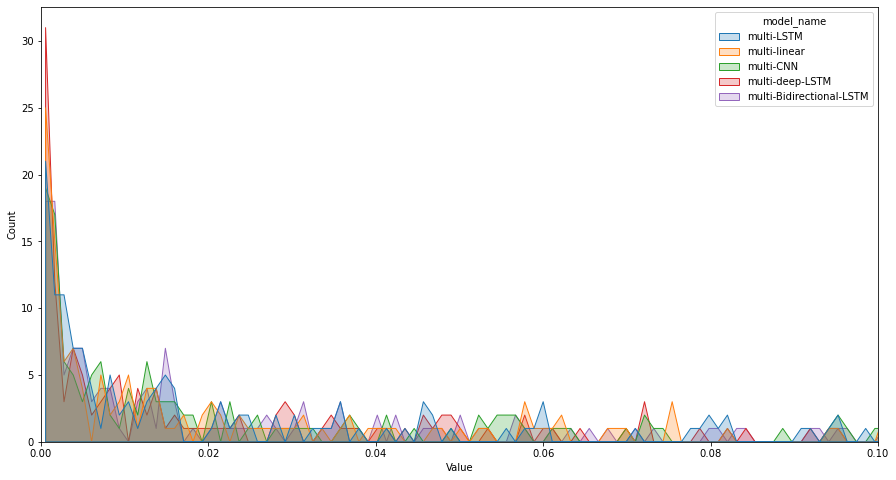

In [131]:
plt.figure(figsize=(15,8))
plt.xlim(0, 0.1)
sns.histplot(melted_baseline_batch[melted_baseline_batch['average_error'] == 'average_window_error_5%'], x='Value', hue='model_name', element='poly', bins=1000)

<AxesSubplot:xlabel='Value', ylabel='model_name'>

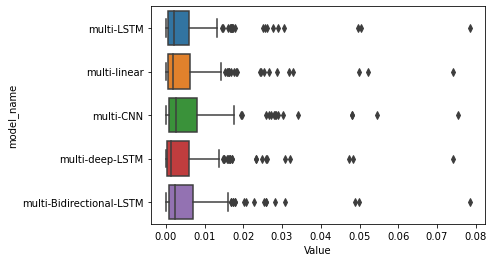

In [13]:
sns.boxplot(x="Value", y="model_name", data=melted_baseline_batch[melted_baseline_batch['average_error'] == 'average_window_error_all'])


In [7]:
LSTM_1 = df_baseline_batch[df_baseline_batch['model_name'] == 'multi-LSTM']['average_window_error_all'].reset_index(drop=True)
Linear_1 = df_baseline_batch[df_baseline_batch['model_name'] == 'multi-linear']['average_window_error_all'].reset_index(drop=True)
CNN_1 = df_baseline_batch[df_baseline_batch['model_name'] == 'multi-CNN']['average_window_error_all'].reset_index(drop=True)
Deep_LSTM_1 = df_baseline_batch[df_baseline_batch['model_name'] == 'multi-deep-LSTM']['average_window_error_all'].reset_index(drop=True)

In [12]:
from scipy.stats import wilcoxon


res_lstm_linear = wilcoxon(Linear_1 - LSTM_1, alternative='greater')
res_lstm_cnn = wilcoxon(CNN_1 - LSTM_1, alternative='greater')
res_lstm_deeplstm = wilcoxon(Deep_LSTM_1 - LSTM_1, alternative='greater')

print(res_lstm_linear.pvalue)
print(res_lstm_cnn.pvalue)
print(res_lstm_deeplstm.pvalue)

0.46079331252315275
9.34874438361527e-06
0.9999999946170034


In [52]:
df_baseline_batch.groupby(['model_name'])[window_error_names_list].mean()

average_window_error_1%  average_window_error_5%  \
model_name                                                                   
multi-Bidirectional-LSTM                 0.183488                 0.064796   
multi-CNN                                0.187009                 0.065886   
multi-LSTM                               0.183181                 0.065216   
multi-deep-LSTM                          0.183631                 0.063197   
multi-linear                             0.185494                 0.064772   

                          average_window_error_10%  average_window_error_25%  \
model_name                                                                     
multi-Bidirectional-LSTM                  0.038611                  0.017619   
multi-CNN                                 0.039072                  0.018104   
multi-LSTM                                0.038937                  0.017761   
multi-deep-LSTM                           0.037076                  0.016552   
multi-linear                              0.038206                  0.017347   

                          average_window_error_50%  average_window_error_75%  \
model_name                                                                     
multi-Bidirectional-LSTM                  0.010109                  0.007305   
multi-CNN                                 0.010710                  0.007955   
multi-LSTM                                0.010126                  0.007244   
multi-deep-LSTM                           0.009250                  0.006502   
multi-linear                              0.009963                  0.007200   

                          average_window_error_all  
model_name                                          
multi-Bidirectional-LSTM                  0.005973  
multi-CNN                                 0.006667  
multi-LSTM                                0.005869  
multi-deep-LSTM                           0.005193  
multi-linear                              0.005895

In [50]:
summary_baseline_batch['average_window_error_1%']['sum'].plot(kind='bar')

KeyError: 'sum'

In [41]:
sorted_results = df_baseline_batch[(df_baseline_batch['model_name'] == 'multi-LSTM') & (df_baseline_batch['label_width'] == 3)].sort_values(by=['average_window_error_5%'])

selected_stations = list(camels_data.summary_data[camels_data.summary_data['state_outlet'] == 'NSW'].index)
train_df, val_df, test_df = camels_data.get_train_val_test(source=['streamflow_MLd_inclInfilled', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP'], stations=selected_stations, discard=0.2)


print(sorted_results.head(3)['station'])
print(sorted_results.tail(3)['station'])

674    419005
672    418005
676    204034
Name: station, dtype: int64
684    212209
660    401009
687    215004
Name: station, dtype: int64


<AxesSubplot:xlabel='date'>

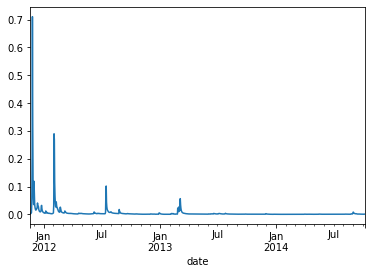

In [46]:
test_df['419005']['streamflow_MLd_inclInfilled'].plot()

<AxesSubplot:xlabel='date'>

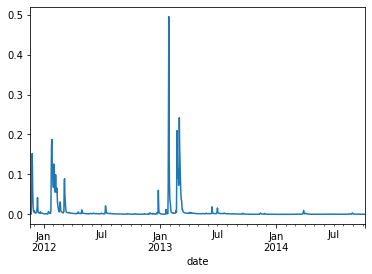

In [47]:
test_df['204034']['streamflow_MLd_inclInfilled'].plot()

<AxesSubplot:xlabel='date'>

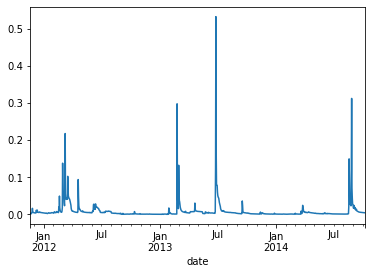

In [48]:
test_df['212209']['streamflow_MLd_inclInfilled'].plot()

<AxesSubplot:xlabel='date'>

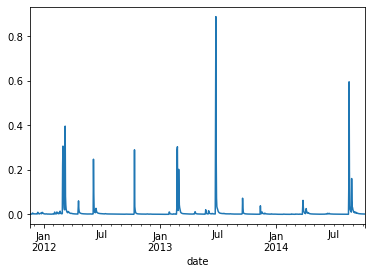

In [52]:
test_df['215004']['streamflow_MLd_inclInfilled'].plot()

In [ ]:
fig, axes = plt.subplots(rows, cols, figsize=(16,12))

In [32]:
grouped_baseline_batch_results

model_name  input_width  label_width  station  \
0                    multi-LSTM            5            1   401009   
1                    multi-LSTM            5            1   401012   
2                    multi-LSTM            5            1   401015   
3                    multi-LSTM            5            1   410057   
4                    multi-LSTM            5            1   410061   
...                         ...          ...          ...      ...   
13855  multi-Bidirectional-LSTM            5            5   215207   
13856  multi-Bidirectional-LSTM            5            5   216002   
13857  multi-Bidirectional-LSTM            5            5   216004   
13858  multi-Bidirectional-LSTM            5            5   218001   
13859  multi-Bidirectional-LSTM            5            5   219001   

                                                  inputs  \
0      ['precipitation_deficit', 'streamflow_MLd_incl...   
1      ['precipitation_deficit', 'streamflow_MLd_incl...   
2      ['precipitation_deficit', 'streamflow_MLd_incl...   
3      ['precipitation_deficit', 'streamflow_MLd_incl...   
4      ['precipitation_deficit', 'streamflow_MLd_incl...   
...                                                  ...   
13855  ['deep_soil', 'precipitation_deficit', 'stream...   
13856  ['deep_soil', 'precipitation_deficit', 'stream...   
13857  ['deep_soil', 'precipitation_deficit', 'stream...   
13858  ['deep_soil', 'precipitation_deficit', 'stream...   
13859  ['deep_soil', 'precipitation_deficit', 'stream...   

                  average_error     Value  
0       average_window_error_1%  0.104758  
1       average_window_error_1%  0.011169  
2       average_window_error_1%  0.016930  
3       average_window_error_1%  0.021658  
4       average_window_error_1%  0.010981  
...                         ...       ...  
13855  average_window_error_all  0.017616  
13856  average_window_error_all  0.006546  
13857  average_window_error_all  0.025557  
13858  average_window_error_all  0.019478  
13859  average_window_error_all  0.005582  

[13860 rows x 7 columns]

In [26]:
summary_columns = sorted(list(camels_data.summary_data.columns))

In [28]:
for i in summary_columns:
    print(i)

Q5
Q95
anngro_mega
anngro_meso
anngro_micro
aridity
baseflow_index
carbnatesed
catchment_area
catchment_di
claya
clayb
confinement
daystart
daystart_P
daystart_Q
distupdamw
drainage_division
elev_max
elev_mean
elev_min
elev_range
elongratio
end_date
erosivity
extract_ind_fac
flow_div_fac
flow_regime_di
frac_snow
geol_prim
geol_prim_prop
geol_sec
geol_sec_prop
gromega_seas
gromeso_seas
gromicro_seas
hdf_mean
high_prec_dur
high_prec_freq
high_prec_timing
high_q_dur
high_q_freq
igneous
impound_fac
infrastruc_fac
ksat
landuse_fac
lat_centroid
lat_outlet
lc01_extracti
lc03_waterbo
lc04_saltlak
lc05_irrcrop
lc06_irrpast
lc07_irrsuga
lc08_rfcropp
lc09_rfpastu
lc10_rfsugar
lc11_wetlands
lc14_tussclo
lc15_alpineg
lc16_openhum
lc18_opentus
lc19_shrbsca
lc24_shrbden
lc25_shrbope
lc31_forclos
lc32_foropen
lc33_woodope
lc34_woodspa
lc35_urbanar
leveebank_fac
long_centroid
long_outlet
low_prec_dur
low_prec_freq
low_prec_timing
low_q_dur
low_q_freq
map_zone
mean_slope_pct
metamorph
mrvbf_prop_0
mrvbf

In [23]:
variables_ts = [['flood_probabilities', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP'],
                ['flood_probabilities', 'precipitation_deficit', 'year_sin', 'year_cos', 'tmax_AWAP', 'tmin_AWAP', 'upper_soil', 'deep_soil'],
                ['flood_probabilities', 'precipitation_deficit']]

variables_static = [[], 
                    ['Q95'],
                    ['Q95', 'high_q_freq', 'high_q_dur'],
                    ['q_mean', 'stream_elas', 'runoff_ratio', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'zero_q_freq'],                    
                    ['elev_mean', 'slope_fdc', 'claya', 'clayb'],
                    ['p_mean', 'p_seasonality', 'pet_mean', 'aridity', 'high_prec_freq', 'high_prec_freq']]

selected_stations = list(camels_data.summary_data[camels_data.summary_data['state_outlet'] == 'NSW'].index)

permutations_ensemble = list(itertools.product(*[variables_ts, variables_static]))

results = []

for ts, static in permutations_ensemble:
    np_window = MultiNumpyWindow(input_width=8, 
                                 label_width=1,
                                 shift=1,
                                 timeseries_source=ts,
                                 summary_source=static,
                                 summary_data=camels_data.summary_data,
                                 stations=selected_stations,
                                 label_columns=['flood_probabilities'])
    
    ensemble_model = Ensemble_Static(np_window)
    ensemble_model.train()
    print('done')
    
    for station in selected_stations:
        results.append(ensemble_model.summary(station))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 TIMESERIES_INPUT (InputLayer)  [(None, 8, 6)]       0           []                               
                                                                                                  
 BIDIRECTIONAL_LAYER_1 (LSTM)   (None, 8, 64)        18176       ['TIMESERIES_INPUT[0][0]']       
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)      (None, 8, 64)        0           ['BIDIRECTIONAL_LAYER_1[0][0]']  
                                                                                                  
 BIDIRECTIONAL_LAYER_2 (LSTM)   (None, 32)           12416       ['DROPOUT_LAYER_1[0][0]']        
                                                                                              

In [24]:
ensemble_results = pd.DataFrame(results)
ensemble_results['timeseries_inputs'] = ensemble_results['timeseries_inputs'].astype(str)
ensemble_results['static_inputs'] = ensemble_results['static_inputs'].astype(str)

In [ ]:
ensemble_results

In [25]:
ensemble_results.groupby(['timeseries_inputs', 'static_inputs']).mean()

input_width  \
timeseries_inputs                                  static_inputs                                                     
['flood_probabilities', 'precipitation_deficit'... ['Q95', 'high_q_freq', 'high_q_dur']                        8.0   
                                                   ['Q95']                                                     8.0   
                                                   ['elev_mean', 'slope_fdc', 'claya', 'clayb']                8.0   
                                                   ['p_mean', 'p_seasonality', 'pet_mean', 'aridit...          8.0   
                                                   ['q_mean', 'stream_elas', 'runoff_ratio', 'high...          8.0   
                                                   []                                                          8.0   
['flood_probabilities', 'precipitation_deficit'... ['Q95', 'high_q_freq', 'high_q_dur']                        8.0   
                                                   ['Q95']                                                     8.0   
                                                   ['elev_mean', 'slope_fdc', 'claya', 'clayb']                8.0   
                                                   ['p_mean', 'p_seasonality', 'pet_mean', 'aridit...          8.0   
                                                   ['q_mean', 'stream_elas', 'runoff_ratio', 'high...          8.0   
                                                   []                                                          8.0   
['flood_probabilities', 'precipitation_deficit']   ['Q95', 'high_q_freq', 'high_q_dur']                        8.0   
                                                   ['Q95']                                                     8.0   
                                                   ['elev_mean', 'slope_fdc', 'claya', 'clayb']                8.0   
                                                   ['p_mean', 'p_seasonality', 'pet_mean', 'aridit...          8.0   
                                                   ['q_mean', 'stream_elas', 'runoff_ratio', 'high...          8.0   
                                                   []                                                          8.0   

                                                                                                       label_width  \
timeseries_inputs                                  static_inputs                                                     
['flood_probabilities', 'precipitation_deficit'... ['Q95', 'high_q_freq', 'high_q_dur']                        1.0   
                                                   ['Q95']                                                     1.0   
                                                   ['elev_mean', 'slope_fdc', 'claya', 'clayb']                1.0   
                                                   ['p_mean', 'p_seasonality', 'pet_mean', 'aridit...          1.0   
                                                   ['q_mean', 'stream_elas', 'runoff_ratio', 'high...          1.0   
                                                   []                                                          1.0   
['flood_probabilities', 'precipitation_deficit'... ['Q95', 'high_q_freq', 'high_q_dur']                        1.0   
                                                   ['Q95']                                                     1.0   
                                                   ['elev_mean', 'slope_fdc', 'claya', 'clayb']                1.0   
                                                   ['p_mean', 'p_seasonality', 'pet_mean', 'aridit...          1.0   
                                                   ['q_mean', 'stream_elas', 'runoff_ratio', 'high...          1.0   
                                                   []                                                          1.0   
['flood_probabilities', 'precipitation_deficit']   ['Q95', 'high_q_freq', 'high_q_dur']   

In [ ]:
# seasonality - month - 
# Q95 - how big the flows are, exceeded at 5% of the time --> Give me indication of height of the peak --> q_uncert_q90_upper
# height of the flow peaks is a function of --> catchment characteristics and rainfall --> characteristics of flow as a predictor --> already takes into account those factors --> 
# average - past flow - better than rainfall
# few flood events -
# gauge heights --> well-behaved series
# normalisation --> scaling 

In [118]:
ensemble_results = pd.read_csv('ensemble_all.csv')

In [119]:
grouped_ensemble_results = (ensemble_results
                            .groupby(['timeseries_inputs', 'static_inputs'])
                            .mean()
                            .reset_index())

grouped_ensemble_results = pd.melt(grouped_ensemble_results,
                                    id_vars=['timeseries_inputs', 'static_inputs'],
                                    value_vars=['average_window_error_1%', 'average_window_error_5%', 'average_window_error_10%', 'average_window_error_25%', 'average_window_error_50%', 'average_window_error_75%', 'average_window_error_all'],
                                    var_name="average_error",
                                    value_name="Value")

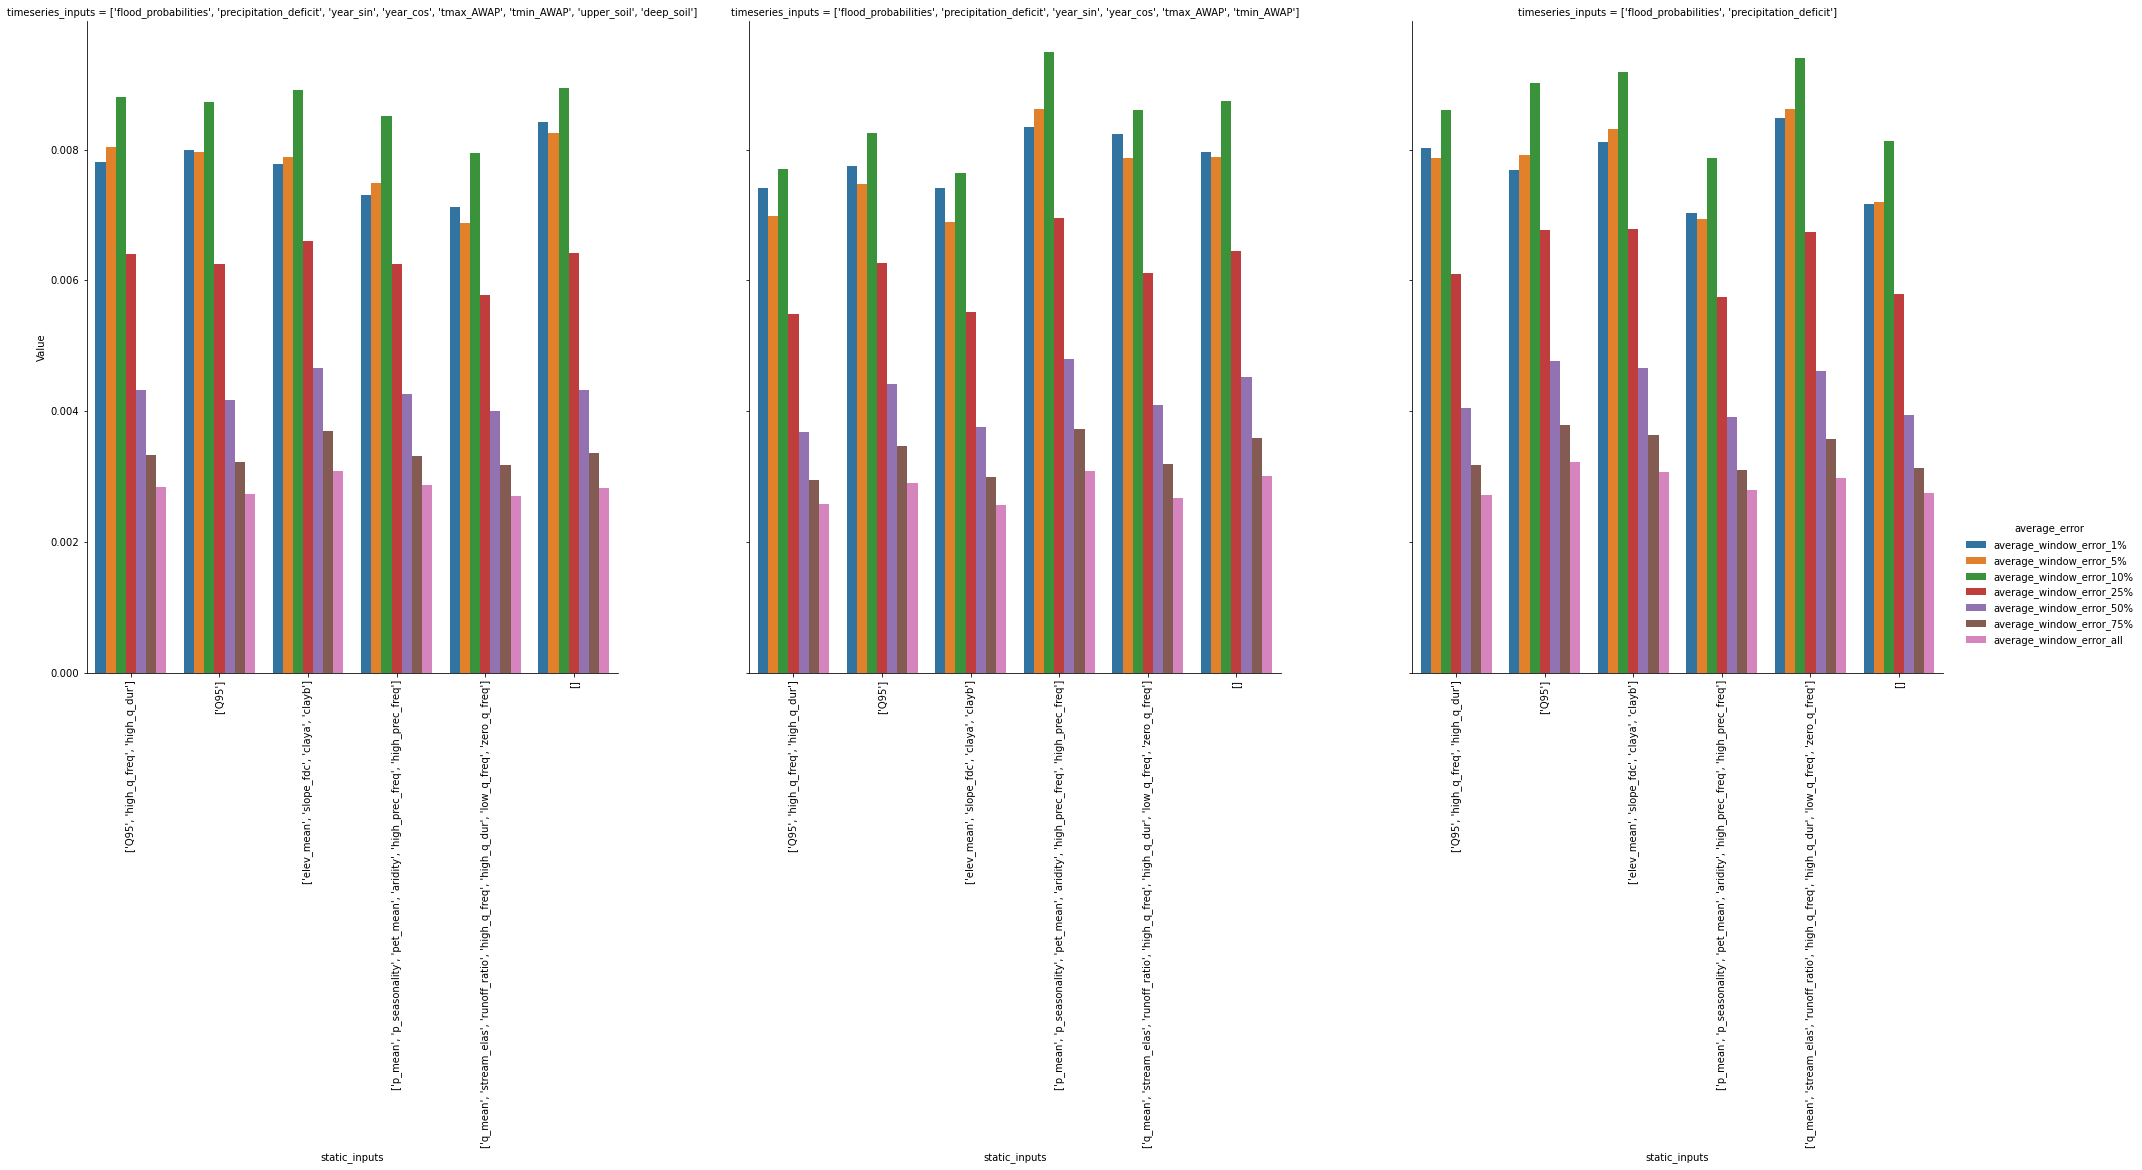

In [68]:
g = sns.catplot(x="static_inputs", y="Value",
                hue="average_error", col="timeseries_inputs",
                data=grouped_ensemble_results, kind="bar", 
                height=10, aspect=0.9);

g.set_xticklabels(rotation=90);